# Projeto de Classificação para Marinha do Brasil

## Autor: Vinícius dos Santos Mello (viniciusdsmello@poli.ufrj.br)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

In [2]:
import os
import pickle
import numpy as np
import time

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam, SGD
import keras.callbacks as callbacks
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K

from sklearn import preprocessing
from sklearn import metrics
from sklearn.externals import joblib

import matplotlib.pyplot as plt

from Functions import TrainParameters as trnparams
from Functions import TrainFunctions
from Functions import FunctionsDataVisualization

import multiprocessing

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'StackedAutoEncoder'

# Enviroment variables
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

# paths to export results
base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/pictures_files'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# For multiprocessing purpose
num_processes = multiprocessing.cpu_count()

# Read data
m_time = time.time()

# Database caracteristics
database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = False
development_events = 400

# Check if LofarData has created...
if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Using Theano backend.
/home/vinicius.mello/.virtualenvs/sonarenvAnnecy/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Time to import all libraries: 2.19345092773e-05 seconds
Time to read data file: 1.0284318924 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [3]:
%time 
# Load train parameters

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.SAENoveltyDetectionTrnParams(n_inits=1,
                                                       hidden_activation='tanh', # others tanh, relu, sigmoid, linear 
                                                       output_activation='linear',
                                                       n_epochs=500, #500
                                                       patience=30, # 30
                                                       batch_size=128, #128
                                                       verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.SAENoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)
    
# Choose how many fold to be used in Cross Validation
n_folds = 10
CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)
print trn_params.get_params_str()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation


# Treinamento da 1 ª Camada - Variação de Neurônios

In [ ]:
# Train example

# Choose neurons topology
max_n_neurons = 475
min_n_neurons = 0
neurons_step = 75

verbose = False

# Create neurons vector to be used in multiprocessing.Pool()
neurons_mat = [1,100,200,250,300,350,400,450]  #range(min_n_neurons, max_n_neurons, neurons_step)
print trn_params.get_params_str()
start_time = time.time()
for inovelty, novelty_class in enumerate(np.unique(trgt)):
    trn_data = all_data[all_trgt!=novelty_class]
    trn_trgt = all_trgt[all_trgt!=novelty_class]

    trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
    
    if inovelty != 0:
        print ''
    print 'Novelty class: %i'%inovelty
    
    def trainNeuron(ineuron):
        n_folds = len(CVO[inovelty])
        for ifold in range(n_folds):
            #print 'Neuron value: %i - fold %i'%(ineuron, ifold)
            TrainFunctions.SAENoveltyTrainFunction(data=trn_data,
                                                       trgt=trn_data,
                                                       inovelty=inovelty,
                                                       ifold=ifold,
                                                       n_folds=n_folds,
                                                       n_neurons=ineuron,
                                                       trn_params=trn_params,
                                                       save_path=results_path,
                                                       layer = 1,
                                                       verbose=verbose,
                                                       dev=development_flag)
    
    
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)
    
    # To train on multiple cores sweeping the number of neurons
    results = p.map(trainNeuron, neurons_mat)
            
    p.close()
    p.join()        

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

# Treinamento da 1ª Camada - Número de Neurônios definido


In [ ]:
# Choose neurons topology
ineuron = 400

verbose = False

print trn_params.get_params_str()

start_time = time.time()
for inovelty, novelty_class in enumerate(np.unique(trgt)):
    trn_data = all_data[all_trgt!=novelty_class]
    trn_trgt = all_trgt[all_trgt!=novelty_class]

    trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
    
    if inovelty != 0:
        print ''
    print 'Novelty class: %i'%inoveltyp
    
    # Array with folds to be trained in parallel
    folds = range(len(CVO[inovelty]))
    
    def trainFold(ifold):
        n_folds = len(CVO[inovelty])
        #print 'Neuron value: %i - fold %i'%(ineuron, ifold)
        TrainFunctions.SAENoveltyTrainFunction(data=trn_data,
                                                   trgt=trn_data,
                                                   inovelty=inovelty,
                                                   ifold=ifold,
                                                   n_folds=n_folds,
                                                   n_neurons=ineuron,
                                                   trn_params=trn_params,
                                                   save_path=results_path,
                                                   layer = 1, # Choose the layer to be trained
                                                   verbose=verbose,
                                                   dev=development_flag)
    
    
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)
    
    # To train on multiple cores sweeping the number of neurons
    results = p.map(trainFold, folds)
            
    p.close()
    p.join()        

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

# Análise de Autocorrelação - 1ª Camada

Novelty class: 1 - neuron: 400 - fold 0
Novelty class: 1 - neuron: 400 - fold 1
Novelty class: 1 - neuron: 400 - fold 2
Novelty class: 1 - neuron: 400 - fold 3
Novelty class: 1 - neuron: 400 - fold 4
Novelty class: 1 - neuron: 400 - fold 5
Novelty class: 1 - neuron: 400 - fold 6
Novelty class: 1 - neuron: 400 - fold 7
Novelty class: 1 - neuron: 400 - fold 8
Novelty class: 1 - neuron: 400 - fold 9


/home/vinicius.mello/.virtualenvs/sonarenvAnnecy/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/vinicius.mello/.virtualenvs/sonarenvAnnecy/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


Topology (1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation)


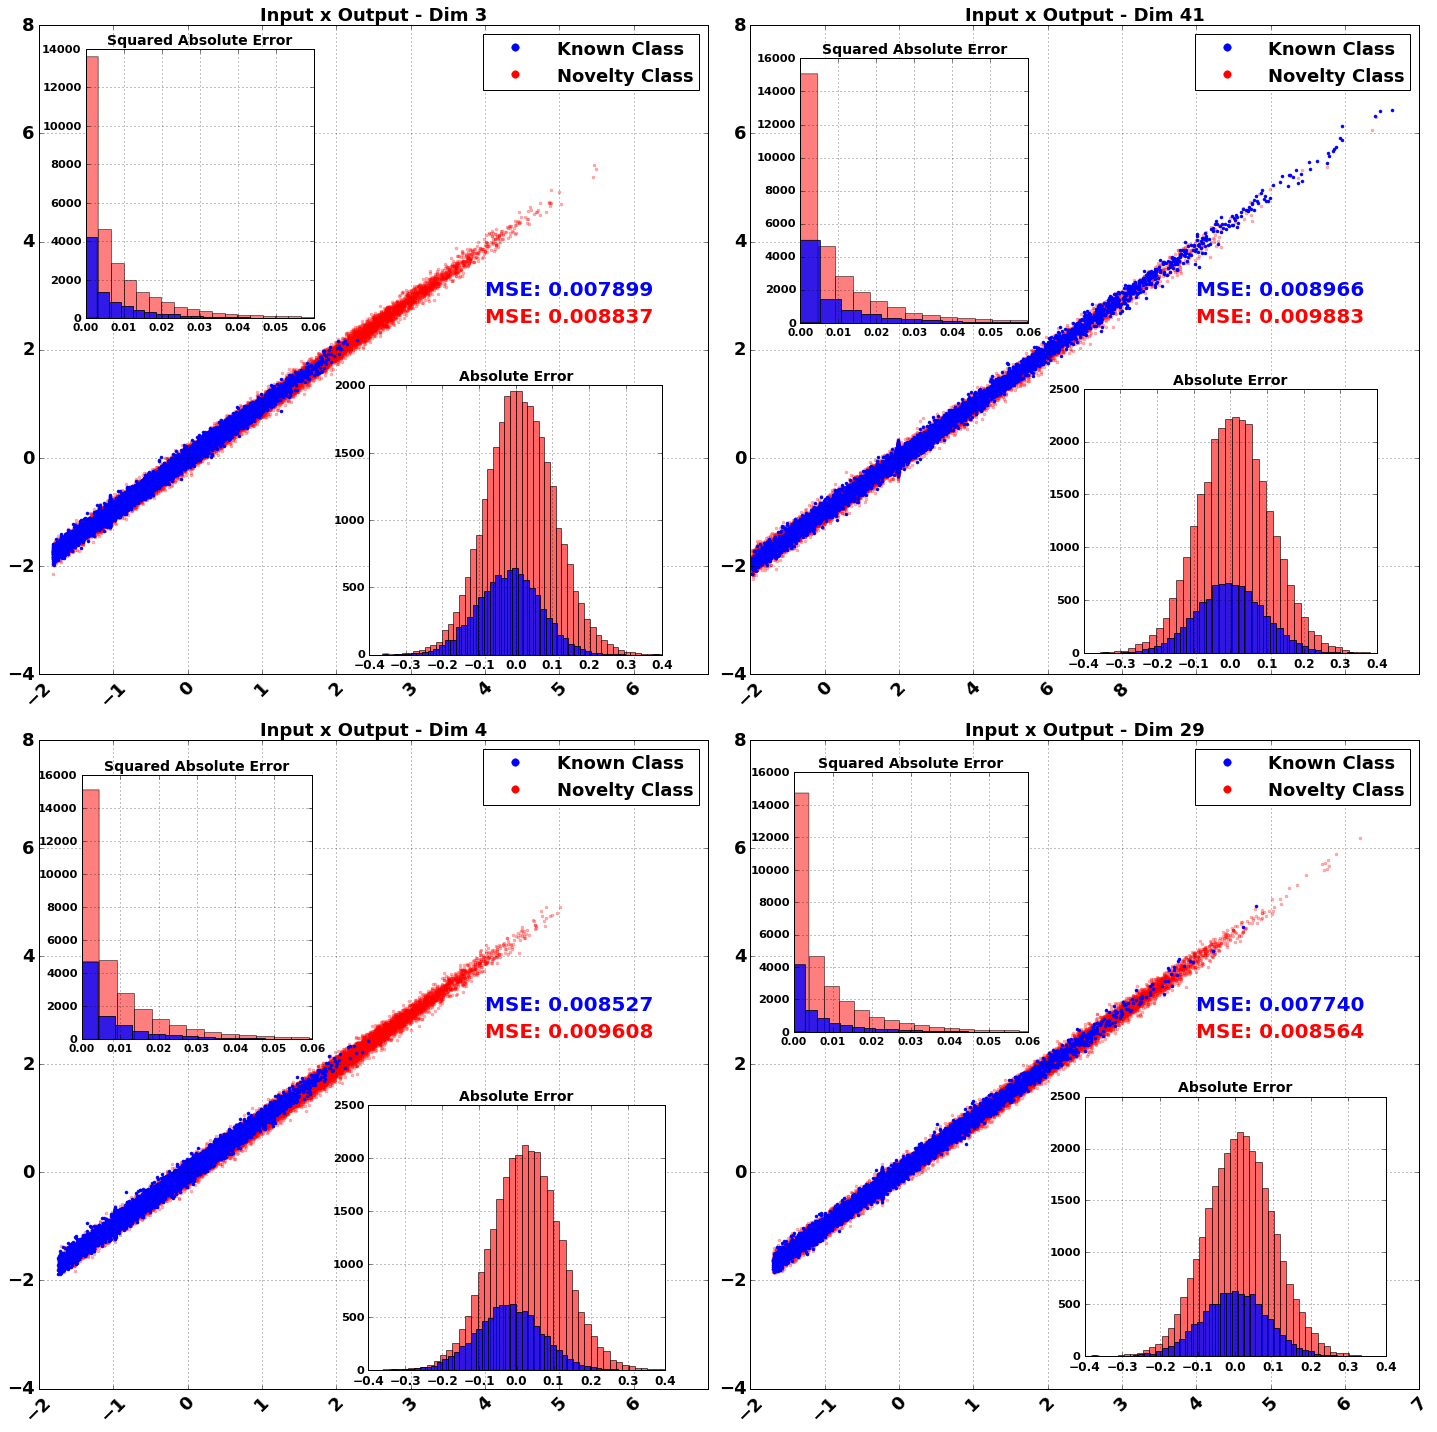

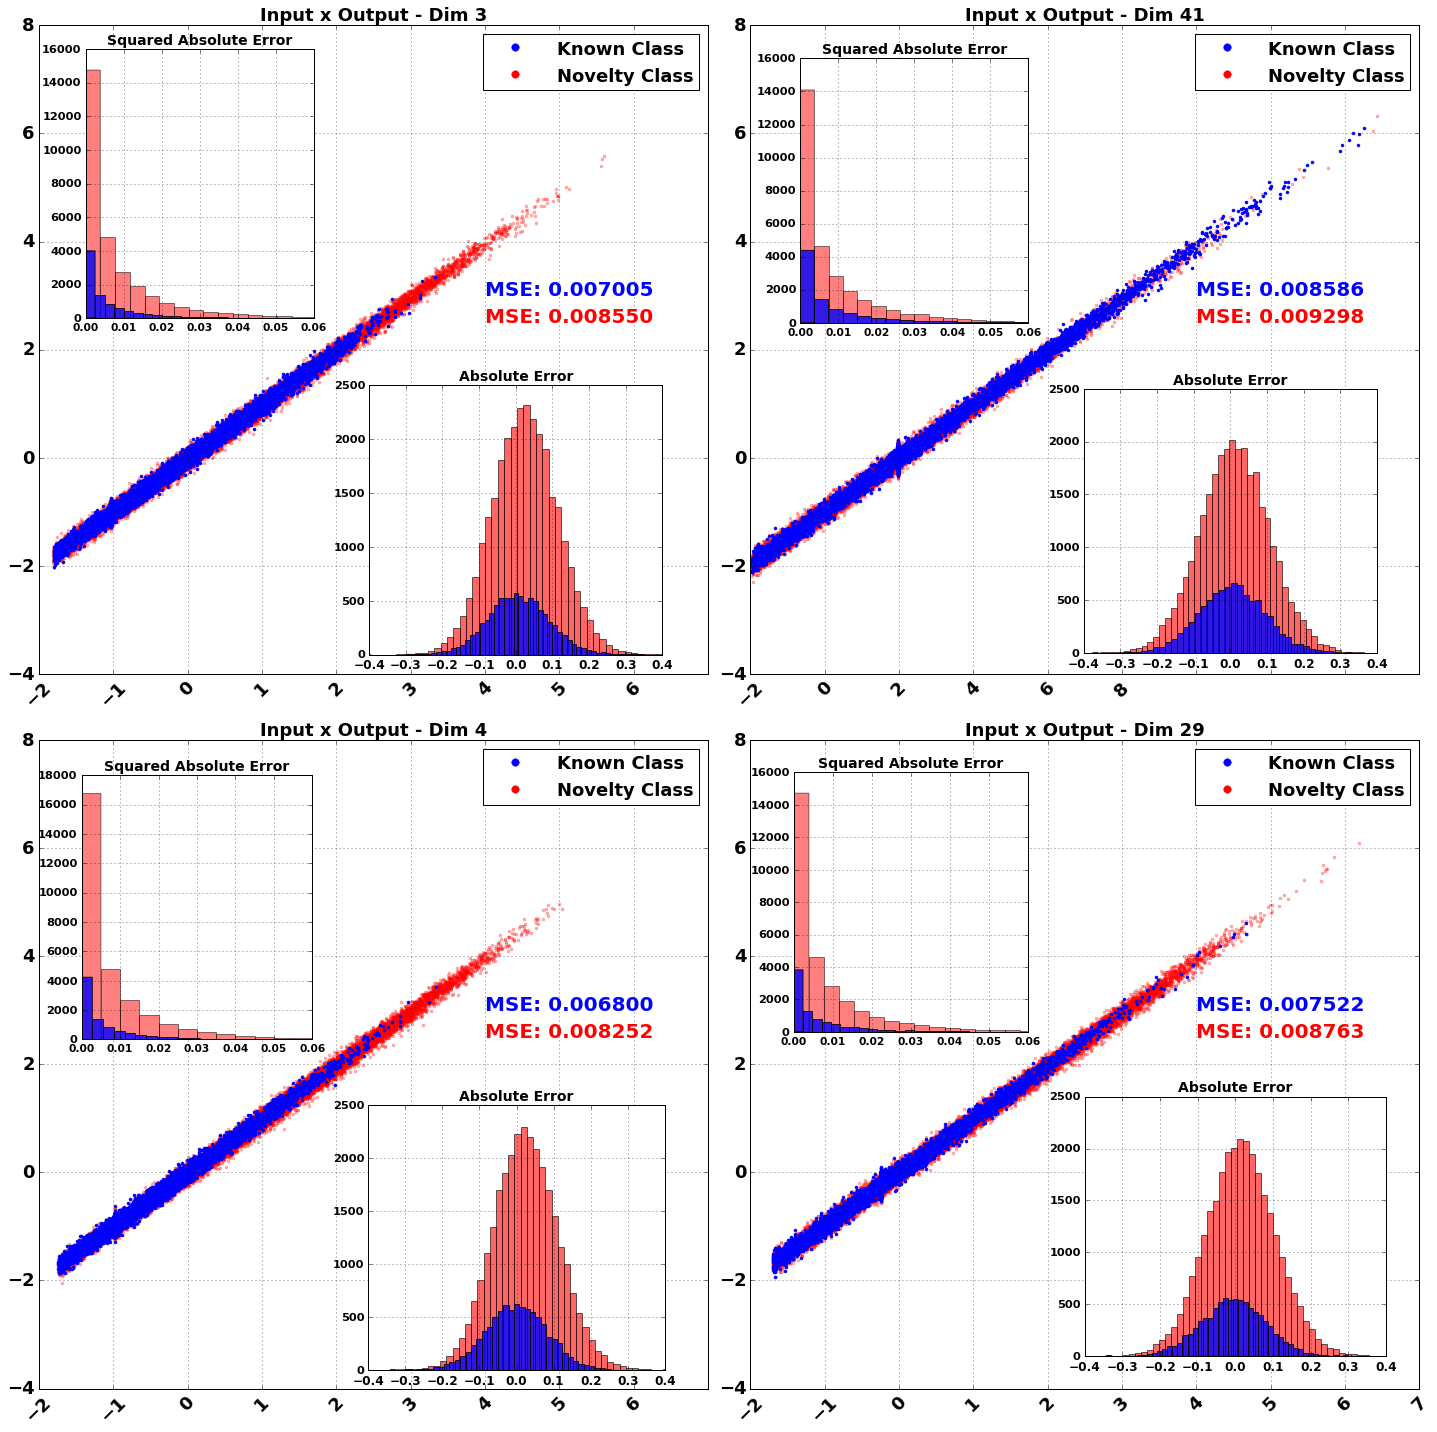

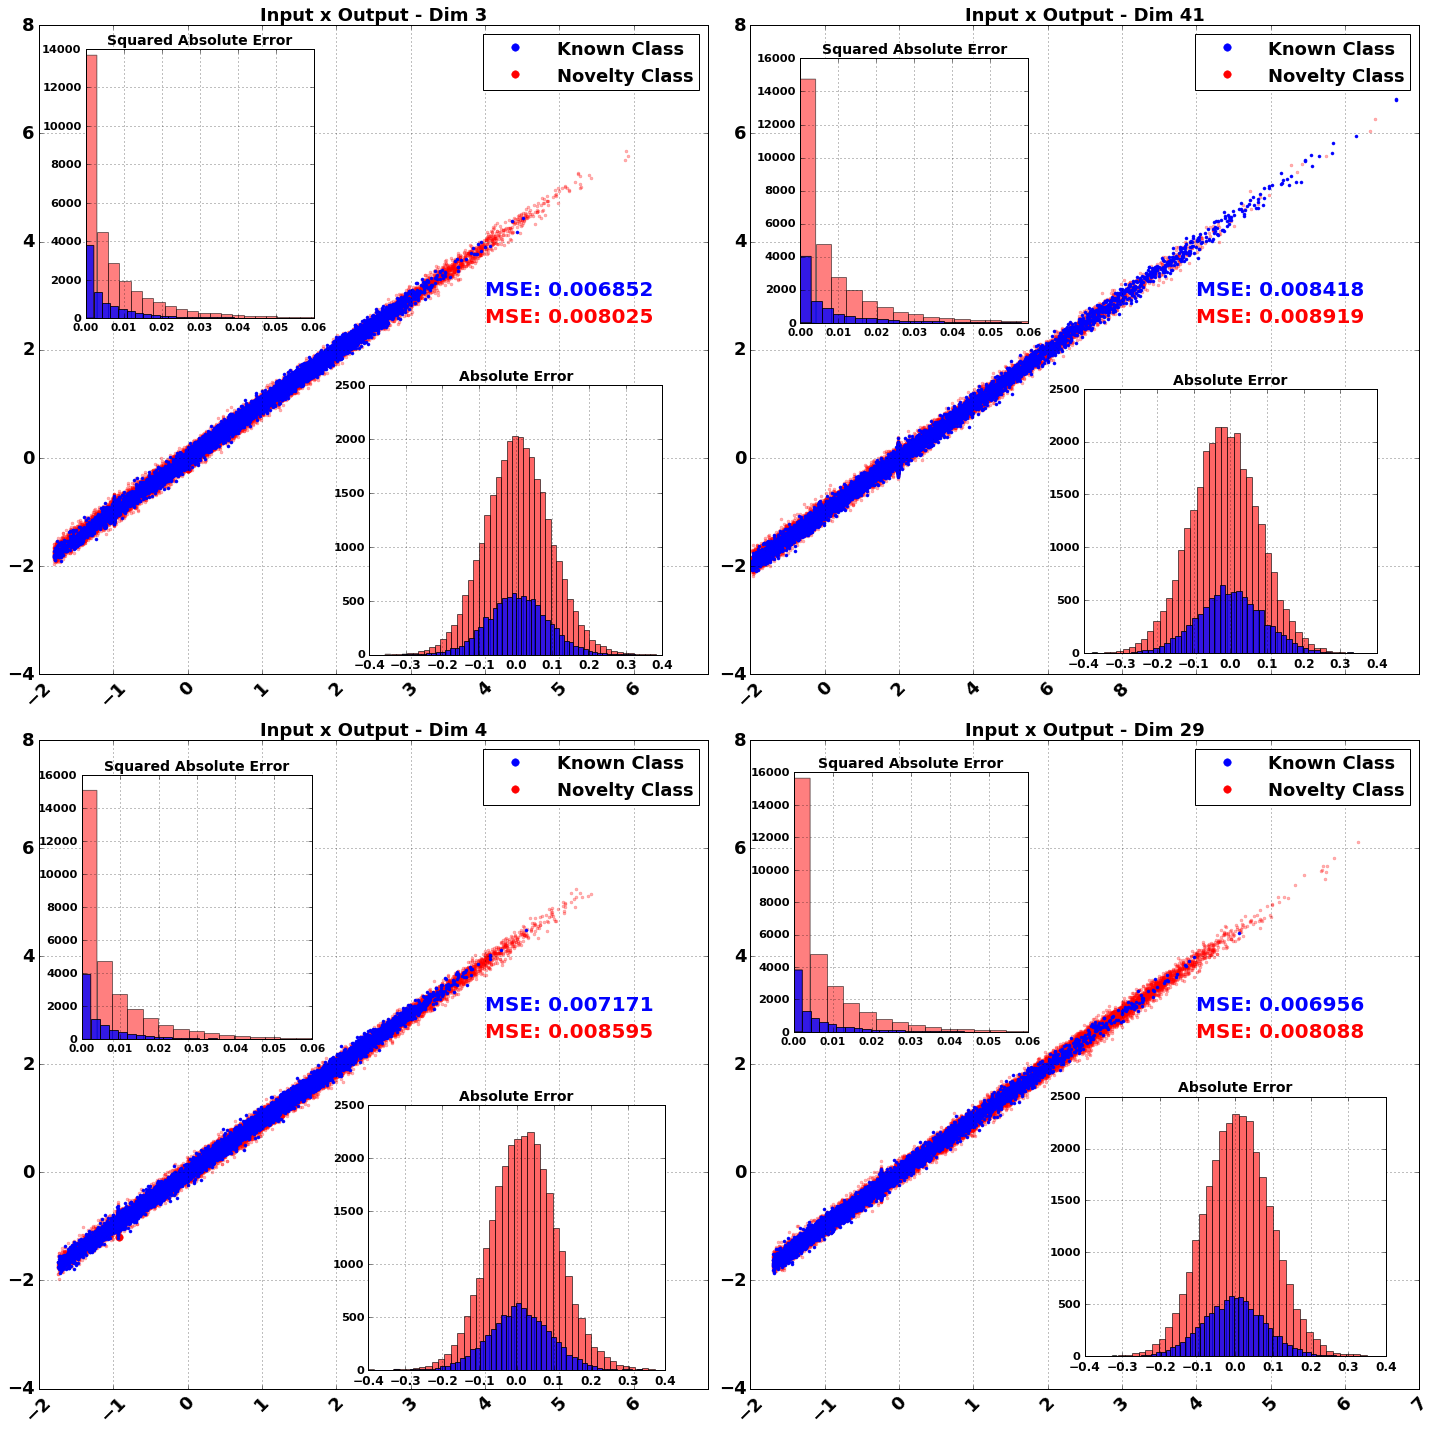

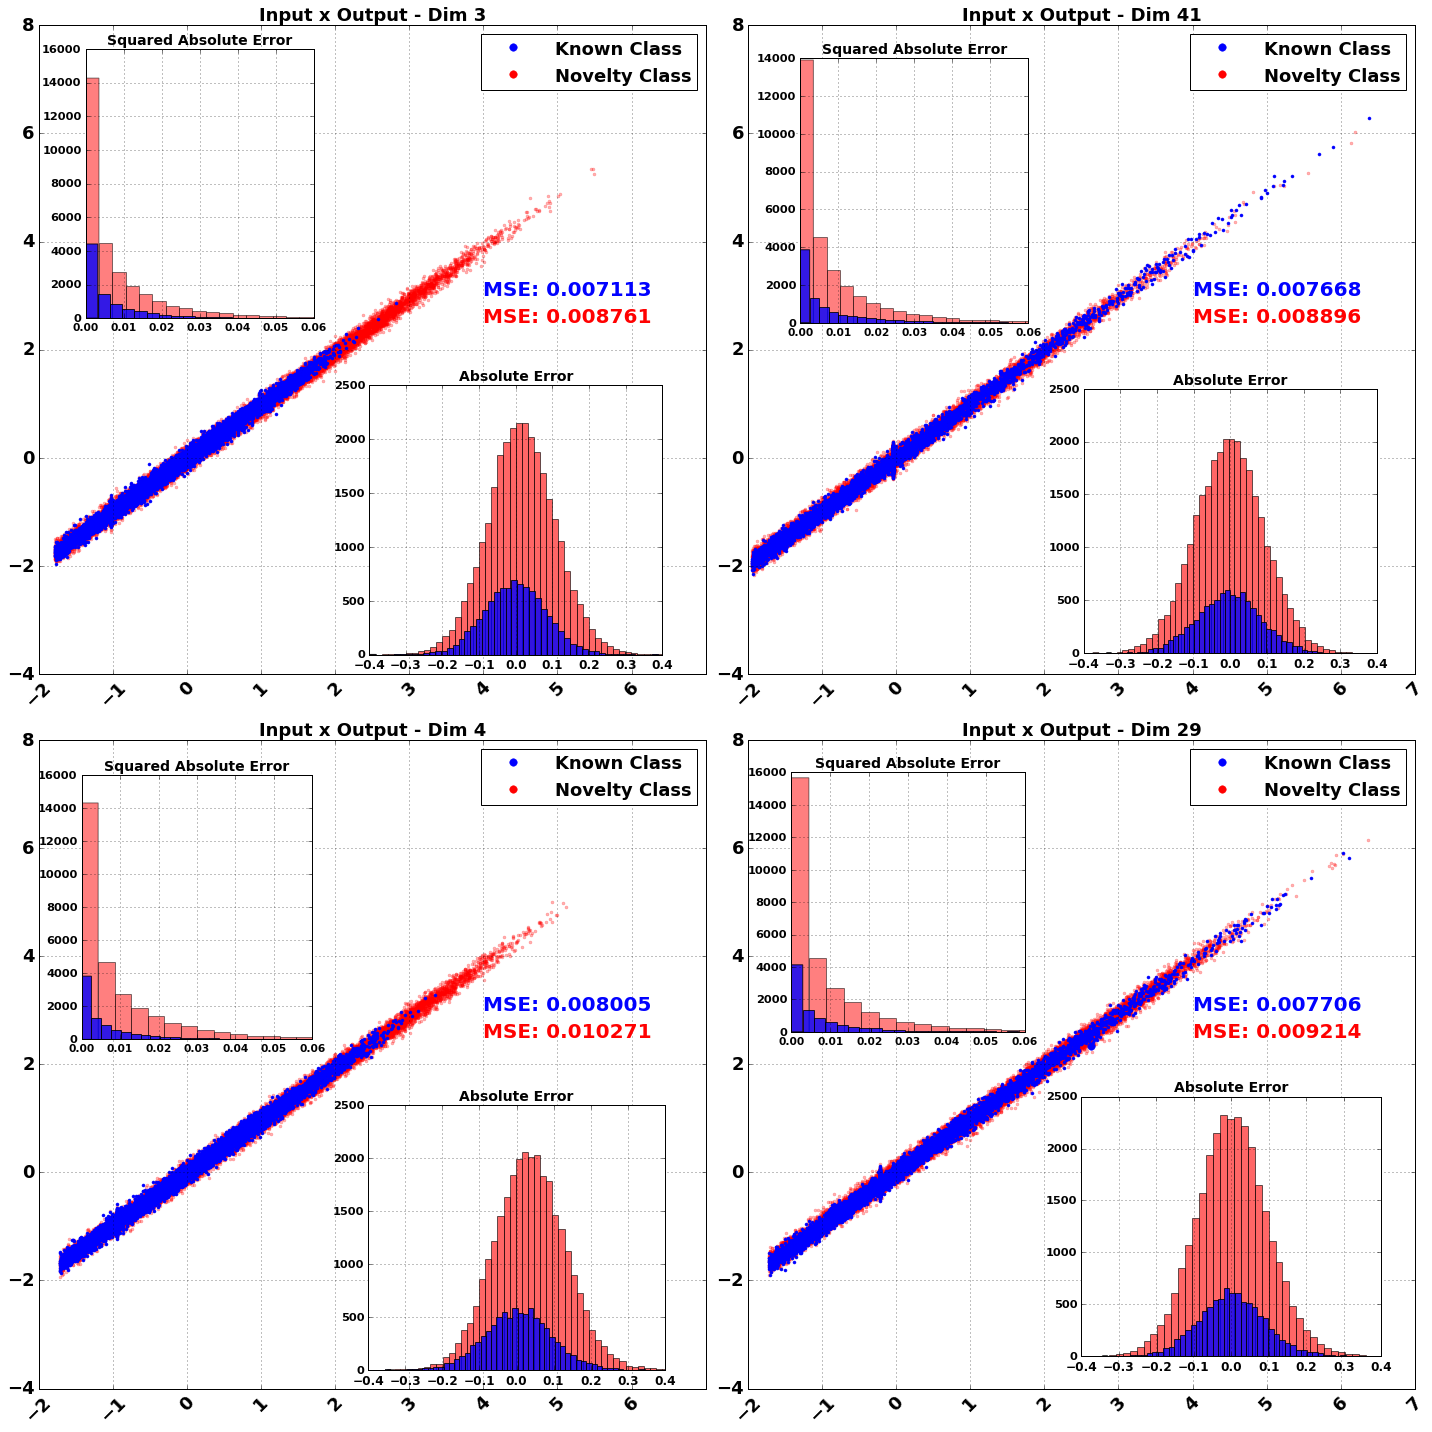

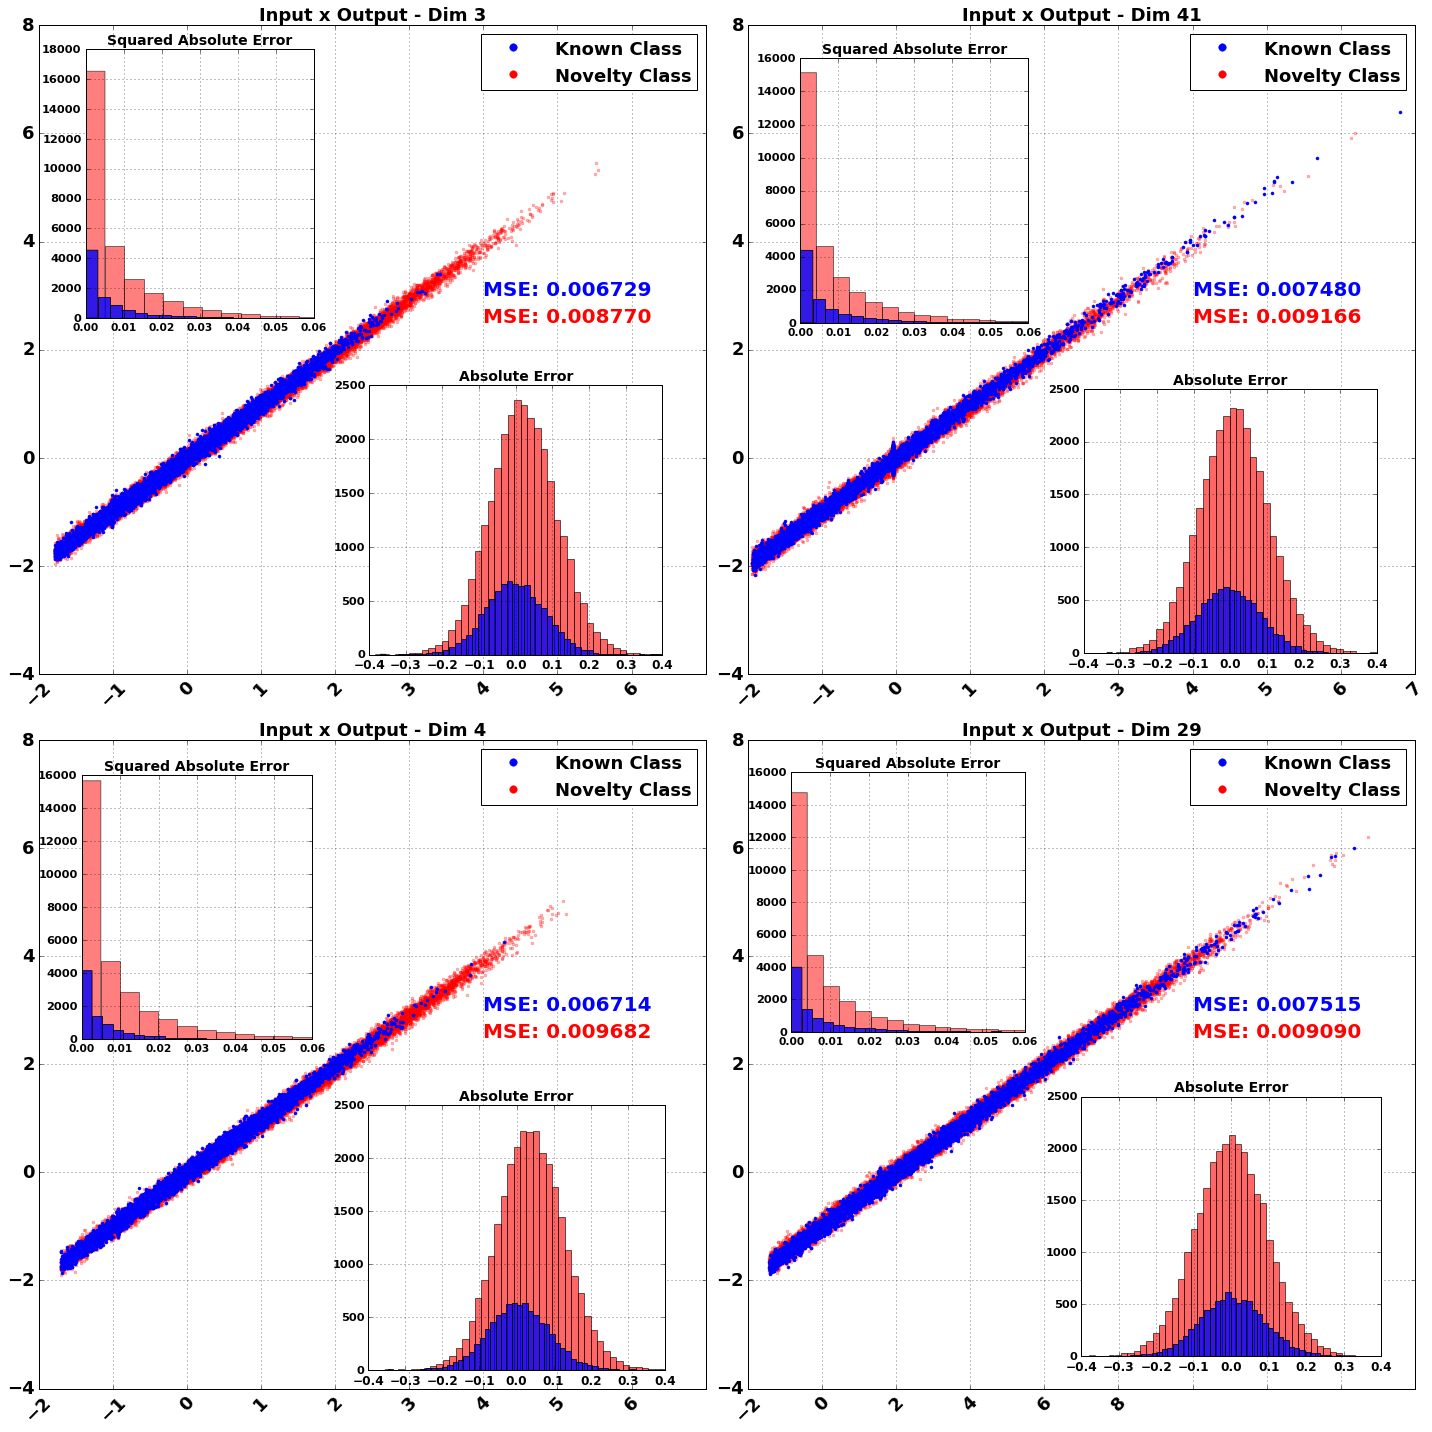

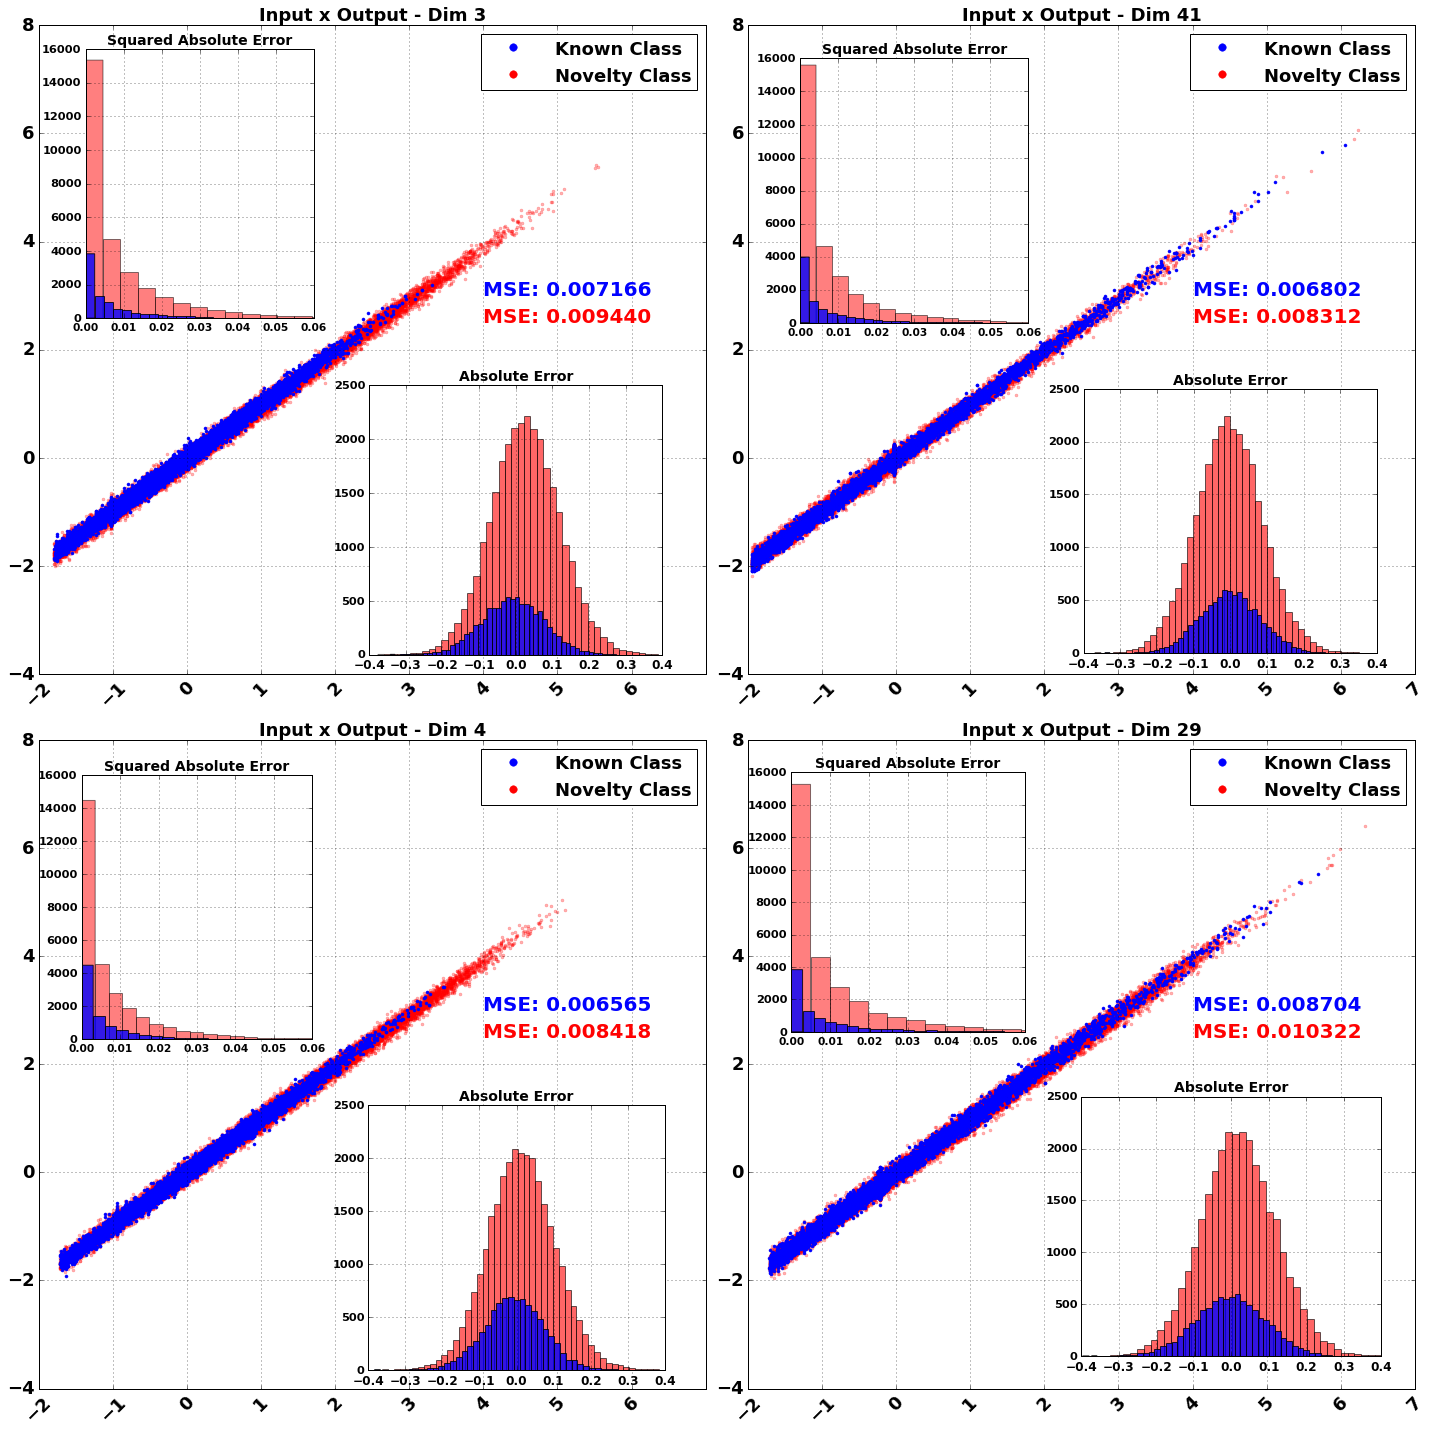

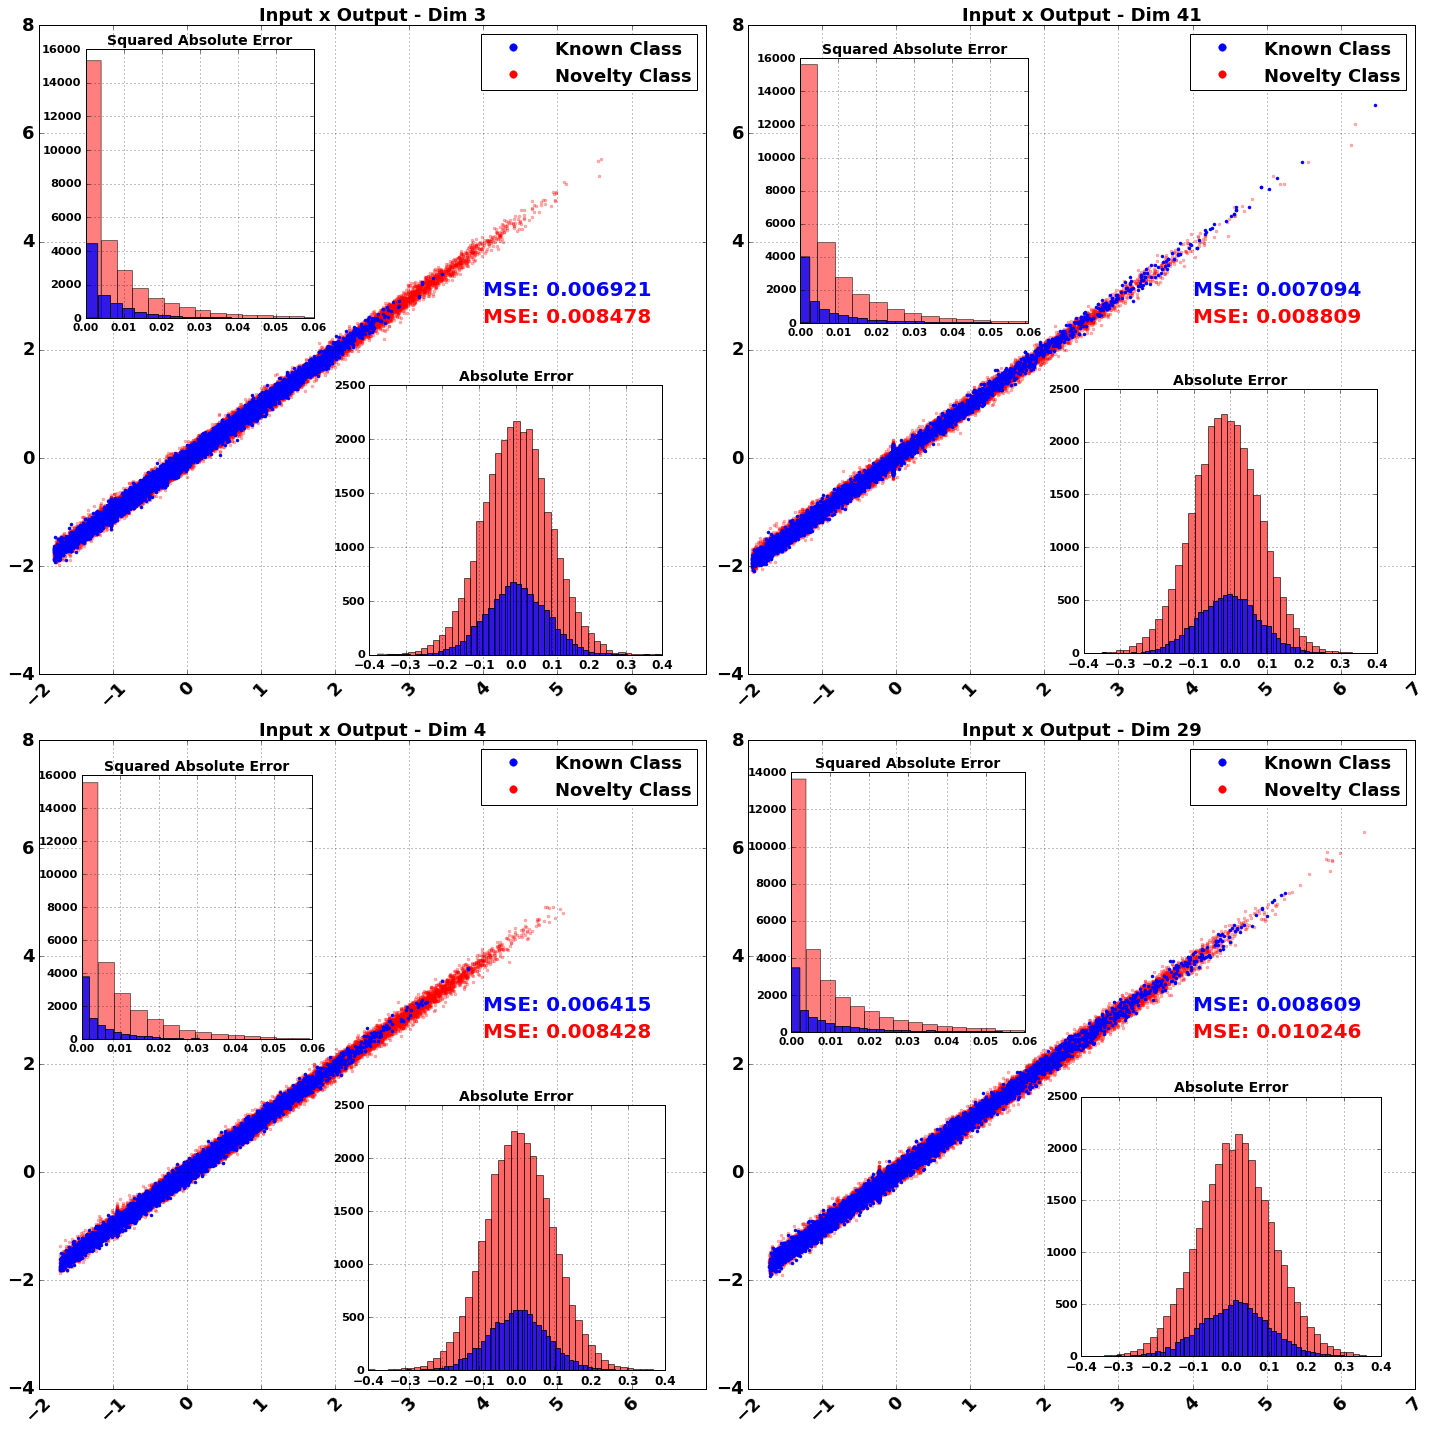

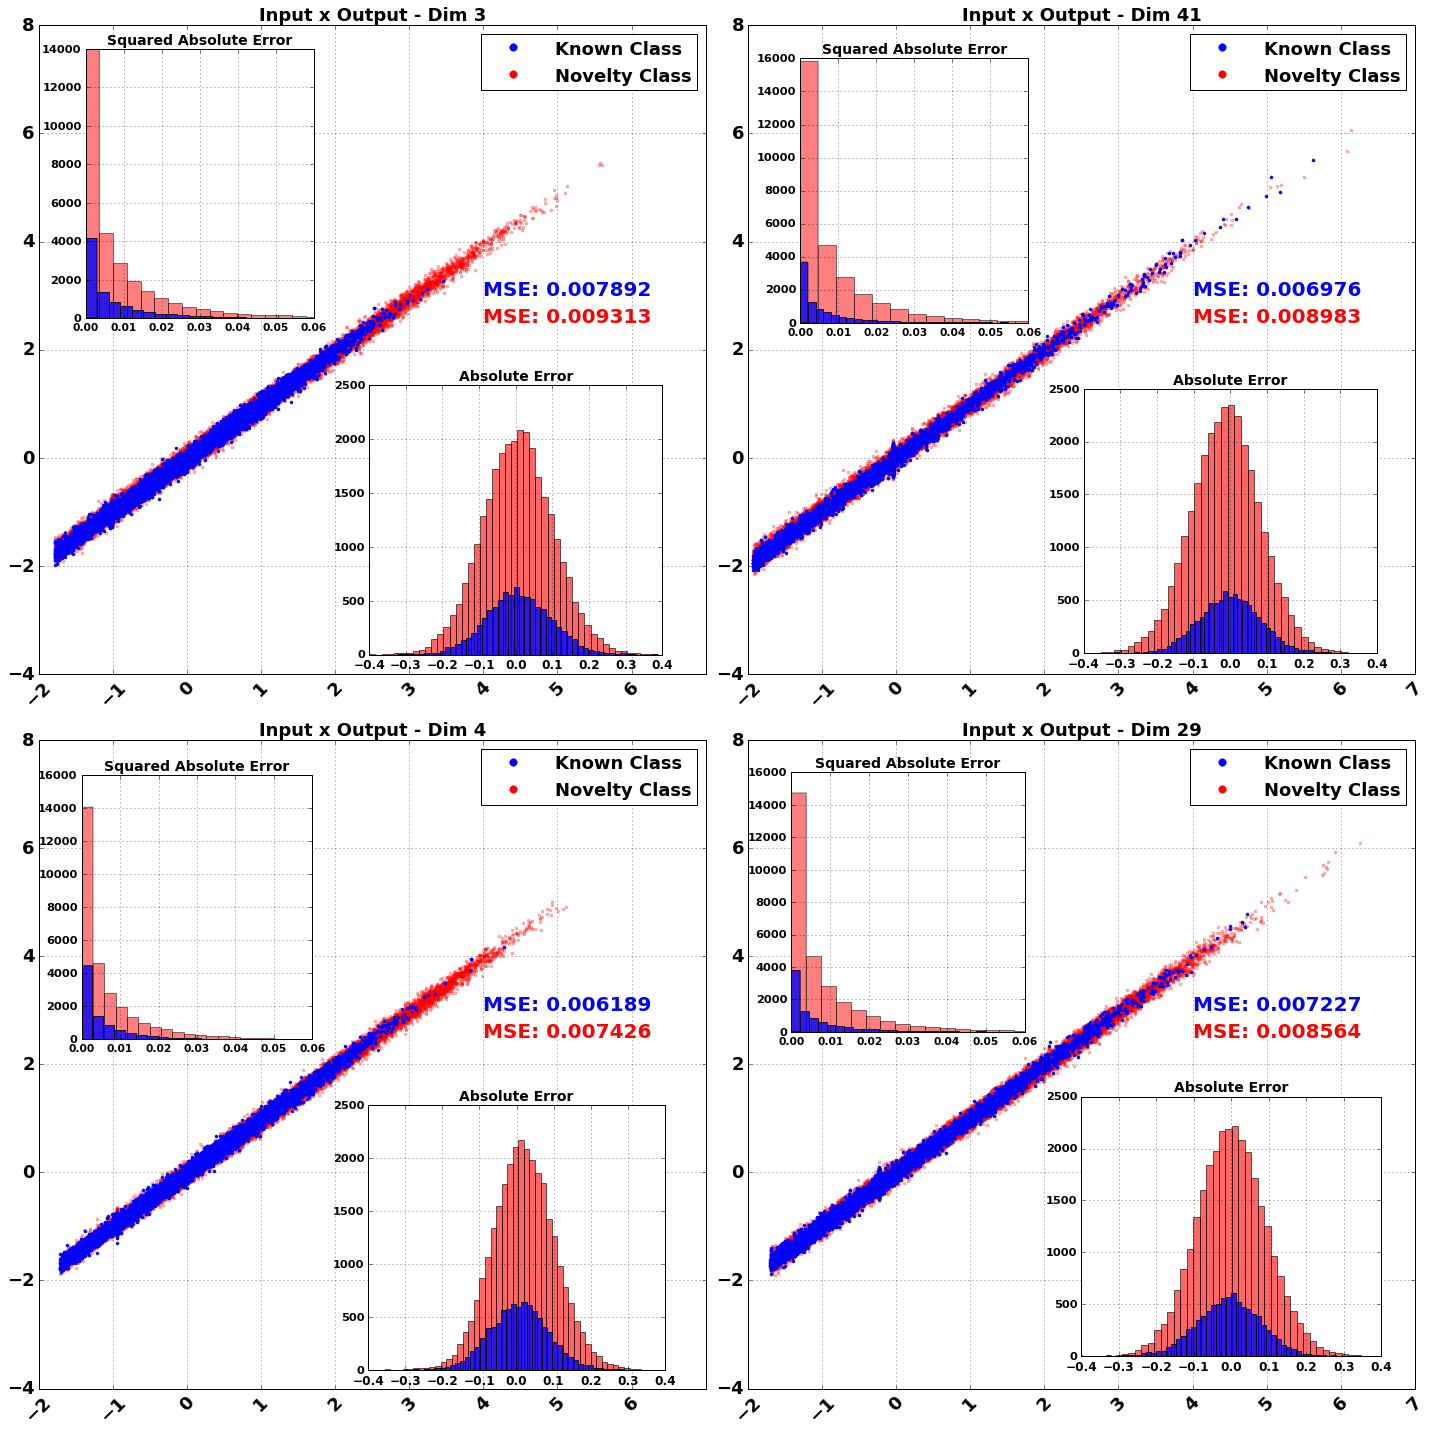

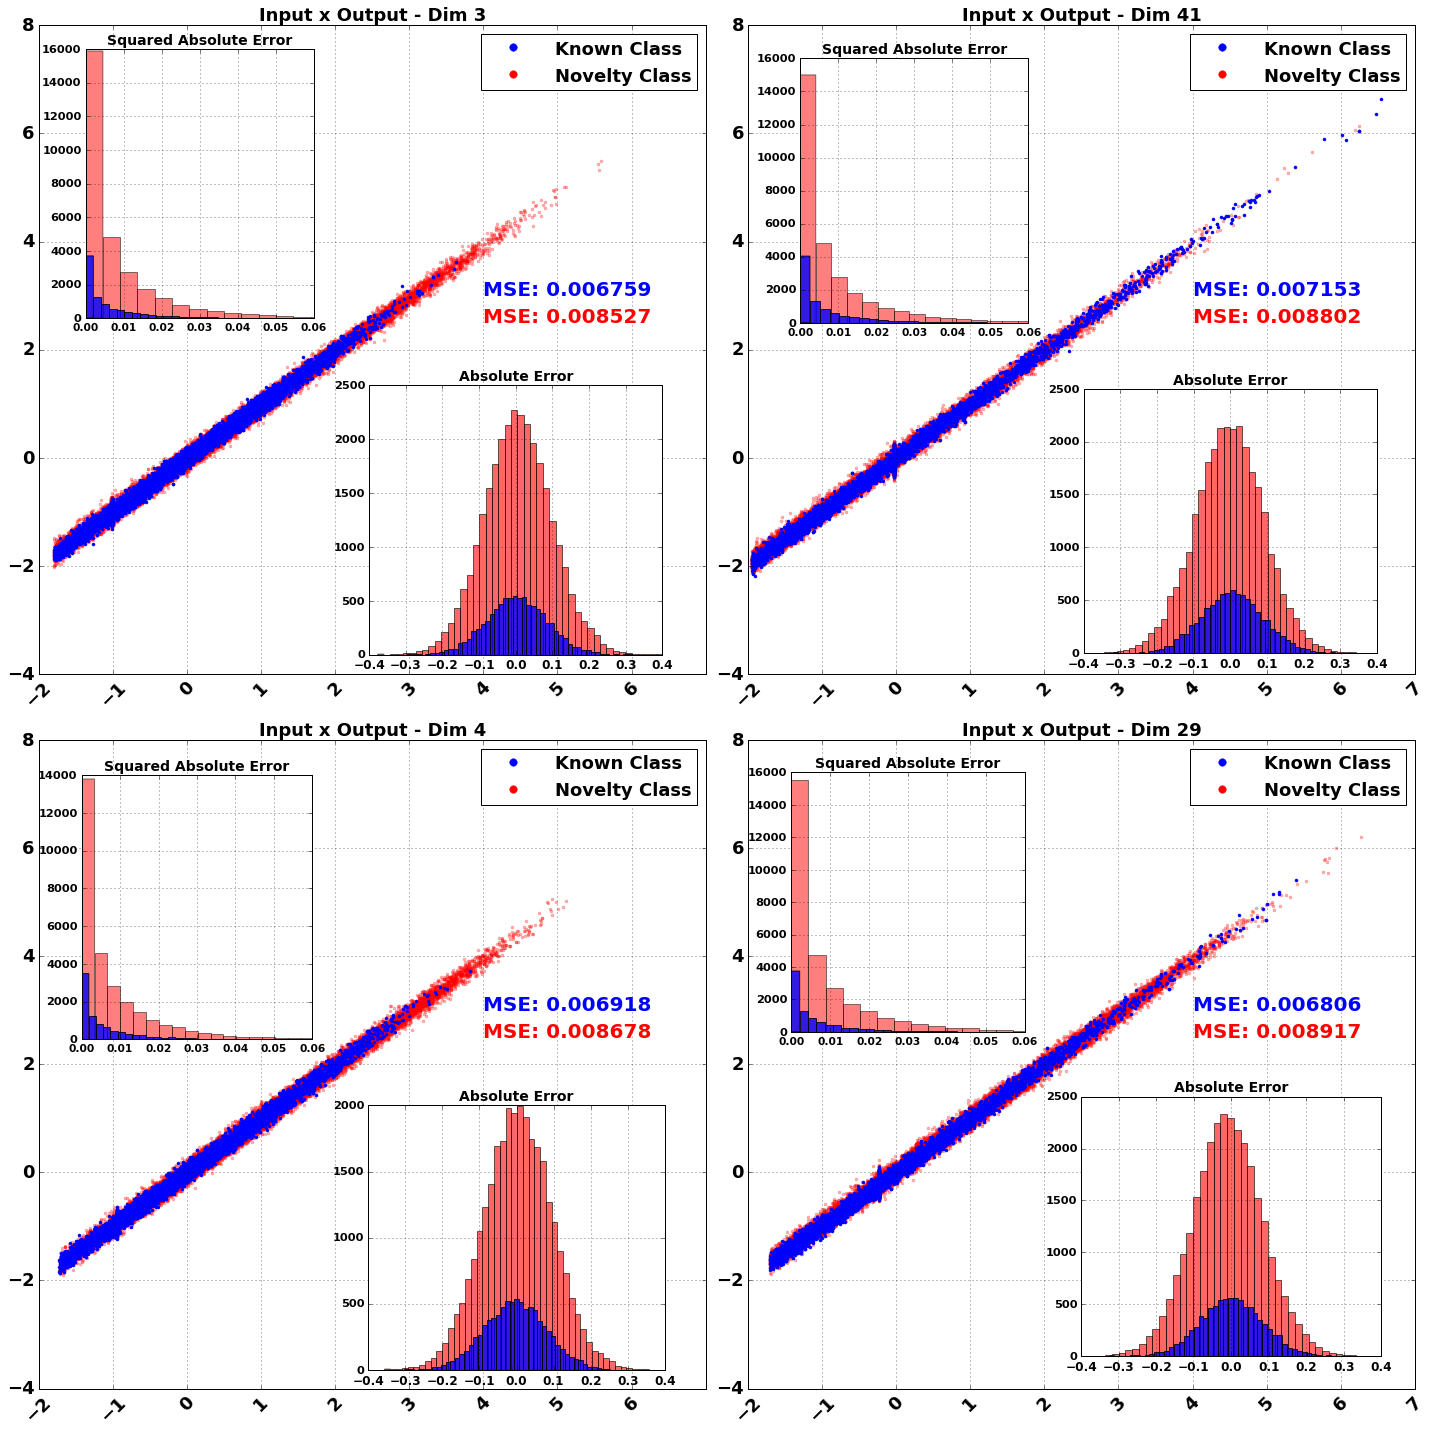

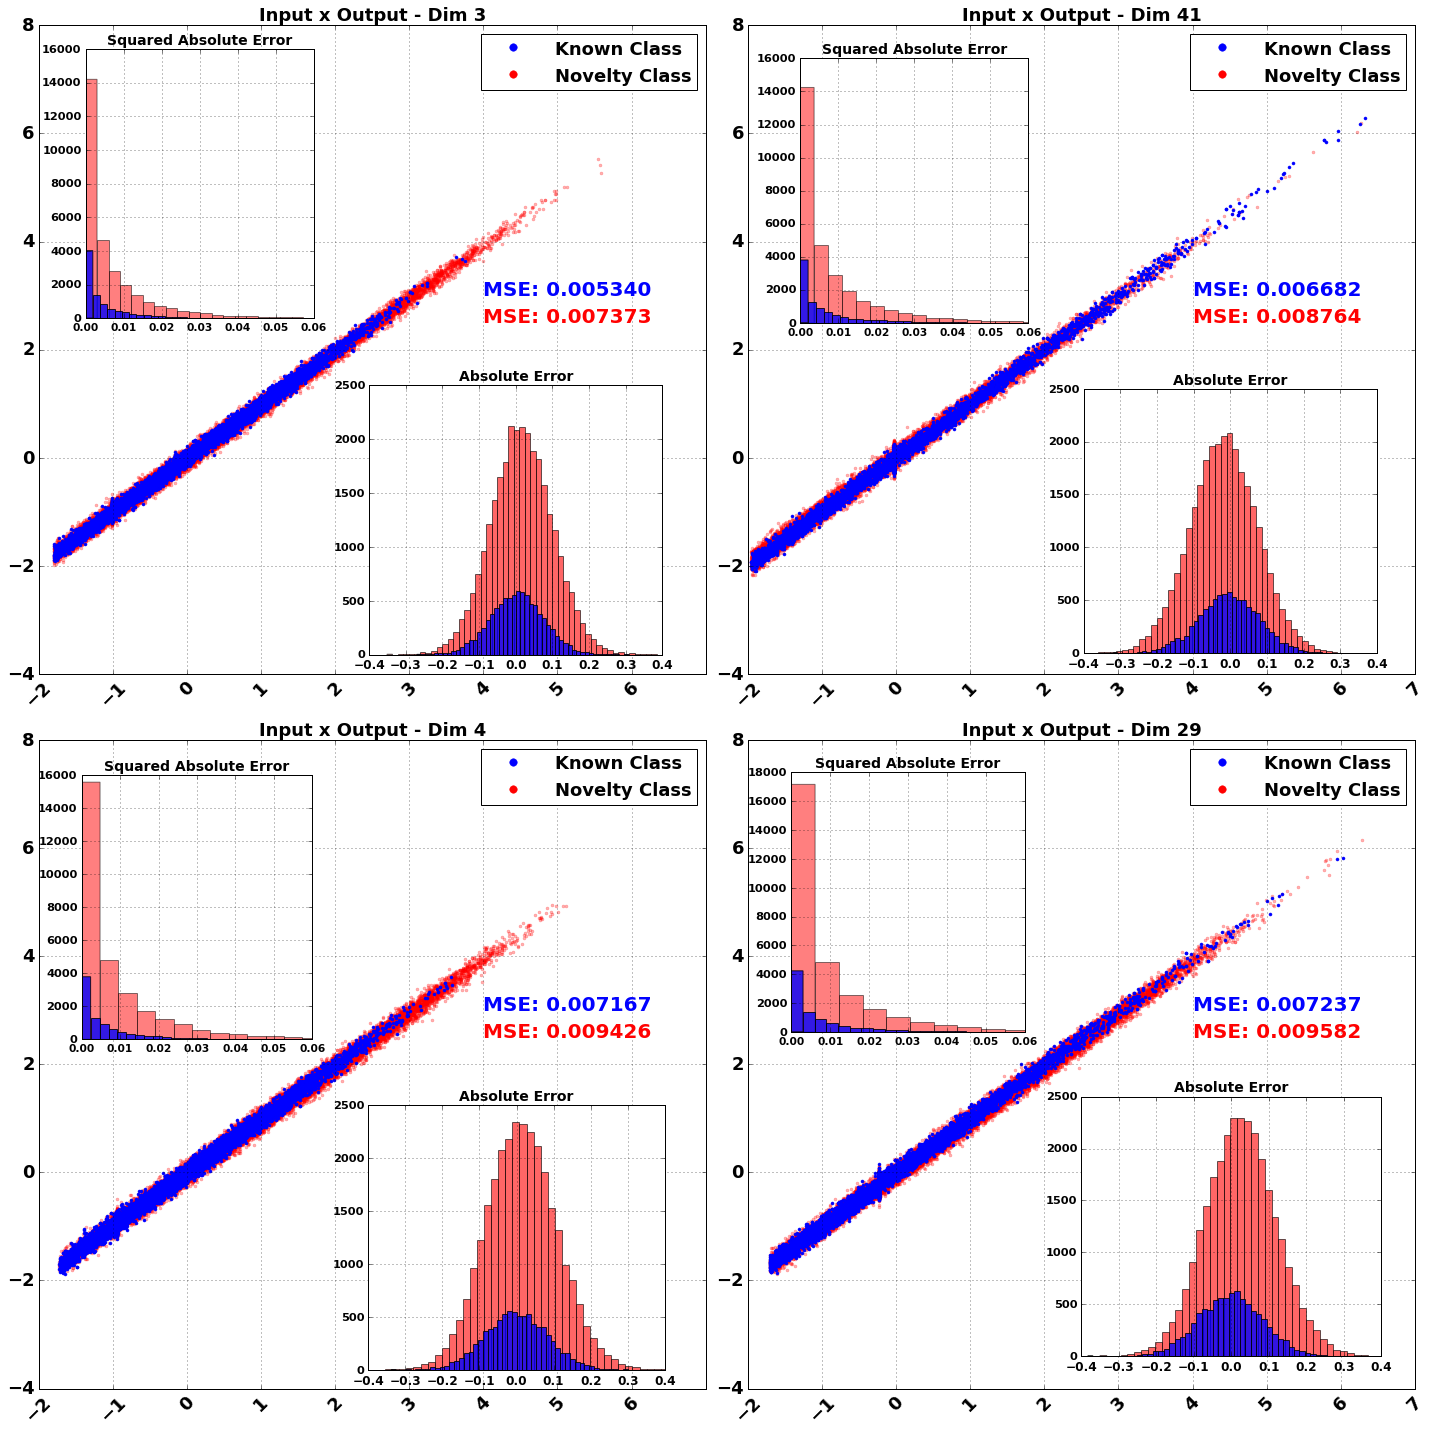

In [37]:
# Reconstruction of Known Classes vs Reconstruction of Novelty - novelty detection for neural network
%matplotlib inline 

# generate analysis data
save_path=results_path

current_analysis = 'reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

# Choose neurons topology
ineuron = 400

# Choose model
inovelty = 1

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

# Check if the analysis has already been performed
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NNNoveltyDetectionTrnParams(n_inits=1,
                                                       hidden_activation='tanh',
                                                       output_activation='linear',
                                                       n_epochs=500,
                                                       patience=30,
                                                       batch_size=256,
                                                       verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NNNoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

novelty_class = float(inovelty)

models = {}
known_outputs = {}
novelty_outputs = {}
mean = {}
indexes = {}

n_folds = len(CVO[inovelty])

for ifold in range(n_folds):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(known_data[test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    if ifold == 0:
        diffSquared = np.zeros([len(CVO[inovelty]), all_data.shape[0], all_data.shape[1]])
        
    print 'Novelty class: %01.0f - neuron: %i - fold %i'%(novelty_class, ineuron, ifold)
    
    neurons_str = str(data.shape[1]) + 'x' + str(ineuron)
    model_str = '%s/%s/%s_%i_novelty_%i_folds_%s_%s_neurons'%(results_path,analysis_str,
                                                               model_prefix_str,inovelty,
                                                               n_folds,params_str,
                                                               neurons_str)
    
    file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    
    if verbose: 
        print file_name
    
    if not os.path.exists(file_name):
        print 'File %s does not exist'%file_name
        break
    models[ifold] = load_model(file_name)
    
    outputs = models[ifold].predict(norm_data)
    known_outputs[ifold] = models[ifold].predict(known_data)
    novelty_outputs[ifold] = models[ifold].predict(novelty_data)
    
    diffSquared[ifold] = np.power((norm_data - outputs), 2)
      
mean = np.mean(np.mean(diffSquared[:,test_id,:], axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    known_data = scaler.transform(known_data[test_id,:])
    
    # normalize novelty classes based on known classes
    novelty_data = all_data[all_trgt==inovelty]
    novelty_data = scaler.transform(novelty_data)
    
    known_points = known_data.shape[0]
    novelty_points = novelty_data.shape[0]
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):  
        ax = plt.subplot(2,2,choose_index+1)
        
        # Plot novelty 
        ax.plot(novelty_data[:,indexes[choose_index]][0], 
                novelty_outputs[ifold][:,indexes[choose_index]][0],
                "r.", label='Novelty Class', markersize=15)
        ax.plot(novelty_data[:,indexes[choose_index]][:novelty_points], 
                novelty_outputs[ifold][:,indexes[choose_index]][:novelty_points],
                "r.", alpha=0.3)
        
        # Plot known classes
        ax.plot(known_data[:,indexes[choose_index]][0],
                known_outputs[ifold][:,indexes[choose_index]][0],
                "b.", label='Known Class', markersize=15)
        ax.plot(known_data[:,indexes[choose_index]][:known_points],
                known_outputs[ifold][:,indexes[choose_index]][:known_points],
                "b.")
        
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.grid() 
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_known_reconstruction = np.power((known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]]), 2)
        eq_novelty_reconstruction = np.power((novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]]), 2)
        
        mq_bins_known = np.linspace(np.min(eq_known_reconstruction), np.max(eq_known_reconstruction), 50)
        mq_bins_novelty = np.linspace(np.min(eq_novelty_reconstruction), np.max(eq_novelty_reconstruction), 50)
             
        n, bins, patches = ax1.hist(eq_novelty_reconstruction,bins=mq_bins_novelty,
                                    fc="r",
                                    alpha=0.5, normed=0)
        
        n, bins, patches = ax1.hist(eq_known_reconstruction,bins=mq_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax1.set_xlim(0, 0.06)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_known_reconstruction = (known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]])
        e_novelty_reconstruction = (novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]])
        
        m_bins_known = np.linspace(np.min(e_known_reconstruction), np.max(e_known_reconstruction), 50)
        m_bins_novelty = np.linspace(np.min(e_novelty_reconstruction), np.max(e_novelty_reconstruction), 50)
        
        n, bins, patches = ax2.hist(e_novelty_reconstruction,bins=m_bins_novelty,
                                    fc="r",
                                    alpha=0.6, normed=0)
        
        n, bins, patches = ax2.hist(e_known_reconstruction,bins=m_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-0.4,0.4) 
        
        ax.legend(handles, labels, ncol=1, loc='upper right')
        plt.legend()
        
        mse = metrics.mean_squared_error(known_data[:,indexes[choose_index]], known_outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 3, 'MSE: %f'%mse, style='normal',fontsize=20, color='blue',
        bbox={'alpha':0.0, 'pad':10})
        
        mse = metrics.mean_squared_error(novelty_data[:,indexes[choose_index]], novelty_outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 2.5, 'MSE: %f'%mse, style='normal',fontsize=20, color='red',
        bbox={'alpha':0.0, 'pad':10})
        
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i_inovelty_first_layer_400x%i_neurons_%i_fold_'%(inovelty, ineuron,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

# Análise LOFAR para reconstrução da novidade - 1ª Camada

In [ ]:
# LOFARGram for reconstructed input 
current_analysis = 'LOFARGram_reconstruction_first_layer'
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

# Choose neurons topology
ineuron = 400

# Choose model
inovelty = 1

# Choose num of lines to plot
points = 100

params_str = trn_params.get_params_str()
    
for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])

    norm_data = scaler.transform(all_data)

    # Get the model file
    model_str = '%s/%s/%s_%i_novelty_%i_folds_%s_400x%i_neurons'%(results_path,analysis_str,
                                                               model_prefix_str,inovelty,
                                                               n_folds,params_str,
                                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    print 'Loading %s'%file_name
    model = load_model(file_name)
    
    all_output = model.predict(norm_data[all_trgt==inovelty])

    m_fontsize = 12

    fig, subplot_array = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        if i == 0:
            plt.imshow(norm_data[all_trgt==inovelty,:],
               cmap="jet",extent=[1, 400, norm_data[all_trgt==inovelty,:].shape[0],1],
               aspect="auto")
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
            plt.title('Lofar Analysis for Original Data of %s'%(class_labels[inovelty]), fontsize= m_fontsize, fontweight="bold")
        if (i == 1):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")
            plt.imshow(all_output,
               cmap="jet",extent=[1, 400, all_output.shape[0],1],
               aspect="auto")
            plt.title('Lofar Analysis for Reconstructed Data of %s'%(class_labels[inovelty]), fontsize= m_fontsize, fontweight="bold")
        
        # Plot lines at frequencies with high errors
        for index in indexes[:points]:
            plt.axvline(index, color='r', alpha=0.7)
            
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i_inovelty'%inovelty+'_%i'%ifold+'_fold'+'_%s'%neurons_str+'_neurons_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

# Treinamento de Classificação - 1ª camada

In [3]:
# Train range of neurons

# Choose neurons topology
hidden_neurons = [400]

verbose = False

start_time = time.time()

print trn_params.get_params_str()
for inovelty, novelty_class in enumerate(np.unique(trgt)):
    trn_data = all_data[all_trgt!=novelty_class]
    trn_trgt = all_trgt[all_trgt!=novelty_class]

    trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
    
    if inovelty != 0:
        print ''
    print 'Novelty class: %i'%inovelty
    
    n_folds = len(CVO[inovelty])
    
    def trainFold(ifold):
        TrainFunctions.SAEClassifierNoveltyTrainFunction(data=trn_data,
                                                   trgt=trn_trgt,
                                                   inovelty=inovelty,
                                                   ifold=ifold,
                                                   n_folds=n_folds,
                                                   hidden_neurons=hidden_neurons,
                                                   trn_params=trn_params,
                                                   save_path=results_path,
                                                   verbose=verbose,
                                                   dev=development_flag)
    
    
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)
    
    folds = range(n_folds)
    
    # To train on multiple cores sweeping the number of folds
    results = p.map(trainFold, folds)
            
    p.close()
    p.join()        

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

1_inits_mapstd_norm_20_epochs_16_batch_size_tanh_hidden_activation_linear_output_activation
Novelty class: 0

Novelty class: 1

Novelty class: 2

Novelty class: 3
It took 7.338 seconds to perform the training


# Análise da variação de Thresholds - 1ª camada

Novelty class: 0 - topology: 400x400 - fold 0
Novelty class: 0 - topology: 400x400 - fold 1
Novelty class: 0 - topology: 400x400 - fold 2
Novelty class: 0 - topology: 400x400 - fold 3
Novelty class: 0 - topology: 400x400 - fold 4
Novelty class: 0 - topology: 400x400 - fold 5
Novelty class: 0 - topology: 400x400 - fold 6
Novelty class: 0 - topology: 400x400 - fold 7
Novelty class: 0 - topology: 400x400 - fold 8
Novelty class: 0 - topology: 400x400 - fold 9
Novelty class: 1 - topology: 400x400 - fold 0
Novelty class: 1 - topology: 400x400 - fold 1
Novelty class: 1 - topology: 400x400 - fold 2
Novelty class: 1 - topology: 400x400 - fold 3
Novelty class: 1 - topology: 400x400 - fold 4
Novelty class: 1 - topology: 400x400 - fold 5
Novelty class: 1 - topology: 400x400 - fold 6
Novelty class: 1 - topology: 400x400 - fold 7
Novelty class: 1 - topology: 400x400 - fold 8
Novelty class: 1 - topology: 400x400 - fold 9
Novelty class: 2 - topology: 400x400 - fold 0
Novelty class: 2 - topology: 400x4

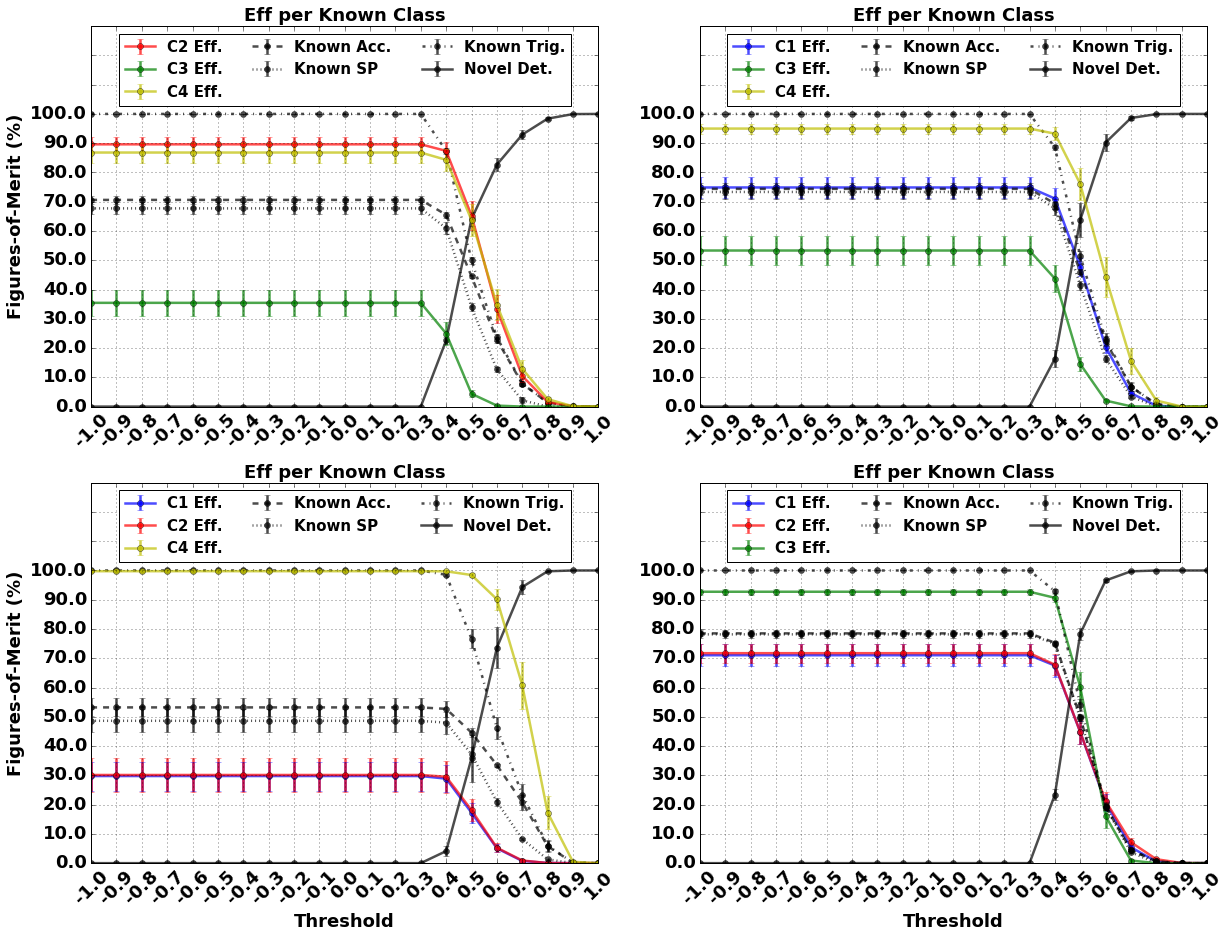

In [32]:
# novelty detection for SAE
# thr. sweep

hidden_neurons = [400]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
    
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_first_layer_thr_sweep.jbl'%(results_path,analysis_str,analysis_name)

# if os.path.exists(analysis_file_name):
#         os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):

    params_str = trn_params.get_params_str()
    
    thr_mat = np.round(np.arange(-1.0,1.1,0.1),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
        trn_data = all_data[all_trgt!=novelty_class]
        trn_trgt = all_trgt[all_trgt!=novelty_class]
        # trgt max = 2
        trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
        
        n_folds = len(CVO[inovelty])
        
        for ifold in range(n_folds):
            print 'Novelty class: %01.0f - topology: %s - fold %i'%(novelty_class, neurons_str, ifold)
            [classifier,trn_desc] = TrainFunctions.SAEClassifierNoveltyTrainFunction(data=trn_data,
                                                   trgt=trn_trgt,
                                                   inovelty=inovelty,
                                                   ifold=ifold,
                                                   n_folds=n_folds,
                                                   hidden_neurons=hidden_neurons,
                                                   trn_params=trn_params,
                                                   save_path=results_path,
                                                   verbose=verbose,
                                                   dev=development_flag)
 
            output = classifier.predict(trn_data)
            novelty_output = classifier.predict(all_data[all_trgt==novelty_class])
            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[trn_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novel Det.')
            ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
            ax.errorbar(thr_mat,np.mean(known_trig_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_trig_mat[:,int(novelty_class),:],axis=0),fmt='o-.',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Trig.')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='C%i Eff.'%(int(m_class)+1))
    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title('Eff per Known Class',fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    ax.set_ylim([0.0, 1.3])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(100*y_ticks[y_ticks<=1.0],fontsize=18)
    
    ax.grid()
    
    if inovelty > 1:
        ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Figures-of-Merit (%)',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
    
    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%s_neurons_'%(neurons_str)+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print trn_params.get_params_str()

# Treinamento da 2º Camada - Número de Neurônios definido

In [ ]:
# Choose neurons topology

# hidden_neurons = [first_layer_dim, second_layer_dim]
hidden_neurons = [400, 350]

layer = 2
verbose = False

print trn_params.get_params_str()

start_time = time.time()
for inovelty, novelty_class in enumerate(np.unique(trgt)):
    trn_data = all_data[all_trgt!=novelty_class]
    trn_trgt = all_trgt[all_trgt!=novelty_class]

    trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
    
    if inovelty != 0:
        print ''
    print 'Novelty class: %i'%inovelty
    
    # Array with folds to be trained in parallel
    folds = range(len(CVO[inovelty]))
    
    def trainFold(ifold):
        n_folds = len(CVO[inovelty])
        #print 'Neuron value: %i - fold %i'%(ineuron, ifold)
        TrainFunctions.SAENoveltyTrainFunction(data=trn_data,
                                                   trgt=trn_data,
                                                   inovelty=inovelty,
                                                   ifold=ifold,
                                                   n_folds=n_folds,
                                                   n_neurons=hidden_neurons[-1],
                                                   trn_params=trn_params,
                                                   save_path=results_path,
                                                   layer = layer, # Choose the layer to be trained
                                                   hidden_neurons = hidden_neurons[:layer-1],
                                                   verbose=verbose,
                                                   dev=development_flag)
    
    
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)
    
    # To train on multiple cores sweeping the number of neurons
    results = p.map(trainFold, folds)
            
    p.close()
    p.join()        

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

# Análise de Autocorrelação - 2ª Camada

In [ ]:
# Reconstruction of Known Classes vs Reconstruction of Novelty - novelty detection for SAE
%matplotlib inline 

# Choose neurons topology
hidden_neurons = [400, 350]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)

# Choose model
inovelty = 1

# generate analysis data
save_path=results_path

current_analysis = 'reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData_%i_novelty'%(inovelty)
verbose = False

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

# Check if the analysis has already been performed
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NNNoveltyDetectionTrnParams(n_inits=1,
                                                       hidden_activation='tanh',
                                                       output_activation='linear',
                                                       n_epochs=500,
                                                       patience=30,
                                                       batch_size=256,
                                                       verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NNNoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

novelty_class = float(inovelty)

models = {}
known_outputs = {}
novelty_outputs = {}
mean = {}
indexes = {}

n_folds = len(CVO[inovelty])

for ifold in range(n_folds):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(known_data[test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    if ifold == 0:
        diffSquared = np.zeros([len(CVO[inovelty]), all_data.shape[0], all_data.shape[1]])
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # print '[*] Loading %s'%file_name
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    # Decoder
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    
    print '[*] Loading fold %i'%ifold
    
    outputs = model.predict(norm_data)
    known_outputs[ifold] = model.predict(known_data)
    novelty_outputs[ifold] = model.predict(novelty_data)
    
    diffSquared[ifold] = np.power((norm_data - outputs), 2)

mean = np.mean(np.mean(diffSquared[:,test_id,:], axis=0), axis=0)
indexes = np.argsort(mean)[::-1]


for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    known_data = scaler.transform(known_data[test_id,:])
    
    # normalize novelty classes based on known classes
    novelty_data = all_data[all_trgt==inovelty]
    novelty_data = scaler.transform(novelty_data)
    
    known_points = known_data.shape[0]
    novelty_points = novelty_data.shape[0]
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):  
        ax = plt.subplot(2,2,choose_index+1)
        
        # Plot novelty 
        ax.plot(novelty_data[:,indexes[choose_index]][0], 
                novelty_outputs[ifold][:,indexes[choose_index]][0],
                "r.", label='Novelty Class', markersize=15)
        ax.plot(novelty_data[:,indexes[choose_index]][:novelty_points], 
                novelty_outputs[ifold][:,indexes[choose_index]][:novelty_points],
                "r.", alpha=0.3)
        
        # Plot known classes
        ax.plot(known_data[:,indexes[choose_index]][0],
                known_outputs[ifold][:,indexes[choose_index]][0],
                "b.", label='Known Class', markersize=15)
        ax.plot(known_data[:,indexes[choose_index]][:known_points],
                known_outputs[ifold][:,indexes[choose_index]][:known_points],
                "b.")
        
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.grid() 
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_known_reconstruction = np.power((known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]]), 2)
        eq_novelty_reconstruction = np.power((novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]]), 2)
        
        mq_bins_known = np.linspace(np.min(eq_known_reconstruction), np.max(eq_known_reconstruction), 50)
        mq_bins_novelty = np.linspace(np.min(eq_novelty_reconstruction), np.max(eq_novelty_reconstruction), 50)
             
        n, bins, patches = ax1.hist(eq_novelty_reconstruction,bins=mq_bins_novelty,
                                    fc="r",
                                    alpha=0.5, normed=0)
        
        n, bins, patches = ax1.hist(eq_known_reconstruction,bins=mq_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax1.set_xlim(0, 0.8)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_known_reconstruction = (known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]])
        e_novelty_reconstruction = (novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]])
        
        m_bins_known = np.linspace(np.min(e_known_reconstruction), np.max(e_known_reconstruction), 50)
        m_bins_novelty = np.linspace(np.min(e_novelty_reconstruction), np.max(e_novelty_reconstruction), 50)
        
        n, bins, patches = ax2.hist(e_novelty_reconstruction,bins=m_bins_novelty,
                                    fc="r",
                                    alpha=0.6, normed=0)
        
        n, bins, patches = ax2.hist(e_known_reconstruction,bins=m_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-1.4,1.4) 
        
        ax.legend(handles, labels, ncol=1, loc='upper right')
        plt.legend()
        
        mse = metrics.mean_squared_error(known_data[:,indexes[choose_index]], known_outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 3, 'MSE: %f'%mse, style='normal',fontsize=15, color='blue',
        bbox={'alpha':0.0, 'pad':10})
        
        mse = metrics.mean_squared_error(novelty_data[:,indexes[choose_index]], novelty_outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 2.5, 'MSE: %f'%mse, style='normal',fontsize=15, color='red',
        bbox={'alpha':0.0, 'pad':10})
        
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i_inovelty_second_layer_%s_neurons_%i_fold_'%(inovelty, neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

# Análise LOFAR para reconstrução de novidade - 2ª Camada

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

# LOFARGram for reconstructed input
current_analysis = 'LOFARGram_reconstruction_second_layer'

# Choose neurons topology
hidden_neurons = [400, 300]
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)

# Choose model
inovelty = 0

# generate analysis data
save_path=results_path

current_analysis = 'reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData_%i_novelty'%(inovelty)

# Create a string like InputDimension x FirstLayerDimension x ... x OutputDimension
neurons_str = '400'
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(all_data.shape[1])

for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    # Decoder
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)
    
    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_(%s)'%neurons_str+'_%i'%ifold+'_fold'+'_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

# Análise da variação de Thresholds - 2ª camada

Novelty class: 0 - topology: 400x400x350 - fold 0
Novelty class: 0 - topology: 400x400x350 - fold 1
Novelty class: 0 - topology: 400x400x350 - fold 2
Novelty class: 0 - topology: 400x400x350 - fold 3
Novelty class: 0 - topology: 400x400x350 - fold 4
Novelty class: 0 - topology: 400x400x350 - fold 5
Novelty class: 0 - topology: 400x400x350 - fold 6
Novelty class: 0 - topology: 400x400x350 - fold 7
Novelty class: 0 - topology: 400x400x350 - fold 8
Novelty class: 0 - topology: 400x400x350 - fold 9
Novelty class: 1 - topology: 400x400x350 - fold 0
Novelty class: 1 - topology: 400x400x350 - fold 1
Novelty class: 1 - topology: 400x400x350 - fold 2
Novelty class: 1 - topology: 400x400x350 - fold 3
Novelty class: 1 - topology: 400x400x350 - fold 4
Novelty class: 1 - topology: 400x400x350 - fold 5
Novelty class: 1 - topology: 400x400x350 - fold 6
Novelty class: 1 - topology: 400x400x350 - fold 7
Novelty class: 1 - topology: 400x400x350 - fold 8
Novelty class: 1 - topology: 400x400x350 - fold 9


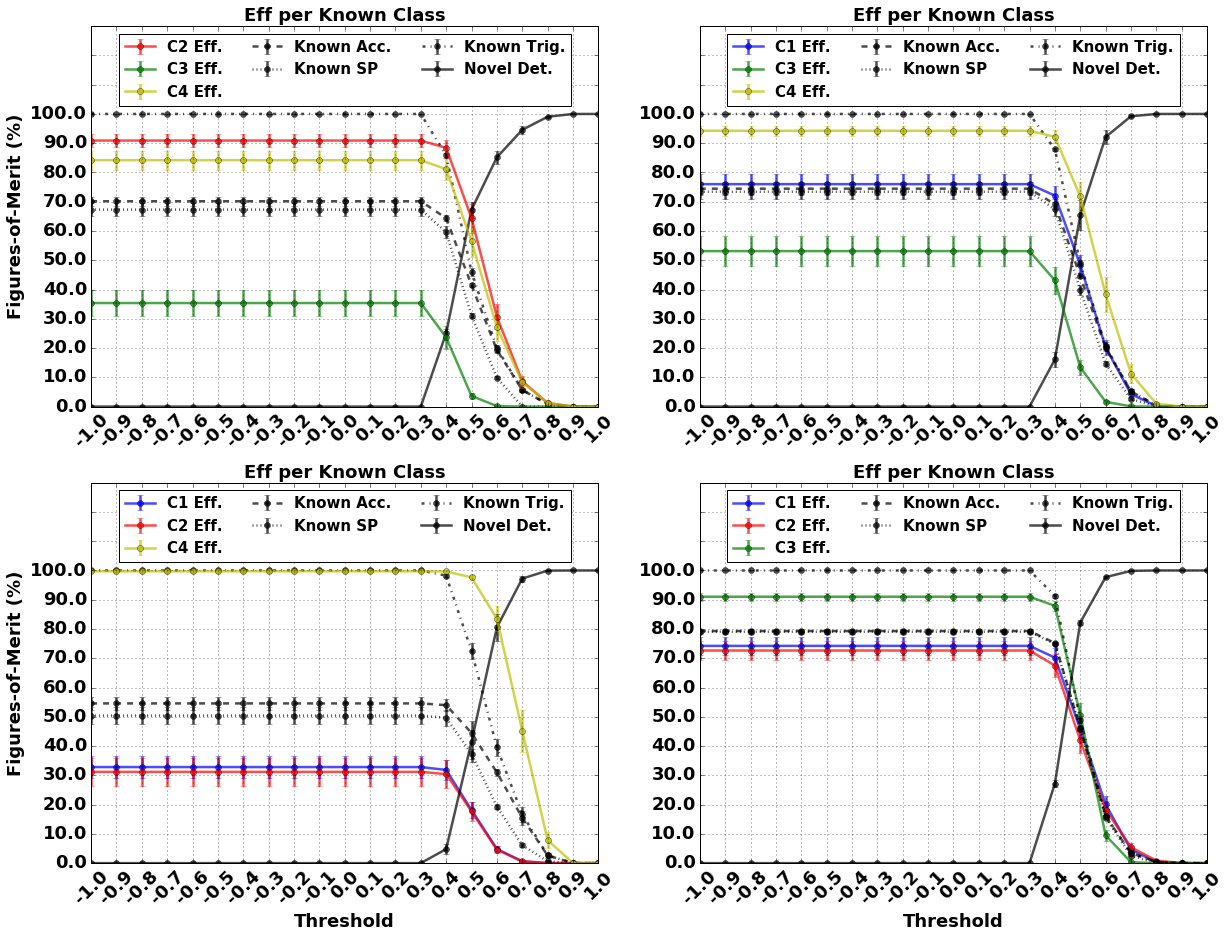

In [33]:
# novelty detection for SAE
# thr. sweep

hidden_neurons = [400, 350]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
    
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_second_layer_thr_sweep.jbl'%(results_path,analysis_str,analysis_name)

# if os.path.exists(analysis_file_name):
#         os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):

    params_str = trn_params.get_params_str()
    
    thr_mat = np.round(np.arange(-1.0,1.1,0.1),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
        trn_data = all_data[all_trgt!=novelty_class]
        trn_trgt = all_trgt[all_trgt!=novelty_class]
        # trgt max = 2
        trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
        
        n_folds = len(CVO[inovelty])
        
        for ifold in range(n_folds):
            print 'Novelty class: %01.0f - topology: %s - fold %i'%(novelty_class, neurons_str, ifold)
            [classifier,trn_desc] = TrainFunctions.SAEClassifierNoveltyTrainFunction(data=trn_data,
                                                   trgt=trn_trgt,
                                                   inovelty=inovelty,
                                                   ifold=ifold,
                                                   n_folds=n_folds,
                                                   hidden_neurons=hidden_neurons,
                                                   trn_params=trn_params,
                                                   save_path=results_path,
                                                   verbose=verbose,
                                                   dev=development_flag)
 
            output = classifier.predict(trn_data)
            novelty_output = classifier.predict(all_data[all_trgt==novelty_class])
            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[trn_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novel Det.')
            ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
            ax.errorbar(thr_mat,np.mean(known_trig_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_trig_mat[:,int(novelty_class),:],axis=0),fmt='o-.',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Trig.')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='C%i Eff.'%(int(m_class)+1))
    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title('Eff per Known Class',fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    ax.set_ylim([0.0, 1.3])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(100*y_ticks[y_ticks<=1.0],fontsize=18)
    
    ax.grid()
    
    if inovelty > 1:
        ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Figures-of-Merit (%)',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
    
    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%s_neurons_%i_fold_'%(neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print trn_params.get_params_str()

# Treinamento da 3ª Camada - Número de Neurônios definido

In [ ]:
# Choose neurons topology

# hidden_neurons = [first_layer_dim, second_layer_dim, third_layer_dim]
hidden_neurons = [400, 350, 300]

layer = 3
verbose = False

print trn_params.get_params_str()

start_time = time.time()
for inovelty, novelty_class in enumerate(np.unique(trgt)):
    trn_data = all_data[all_trgt!=novelty_class]
    trn_trgt = all_trgt[all_trgt!=novelty_class]

    trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
    
    if inovelty != 0:
        print ''
    print 'Novelty class: %i'%inovelty
    
    # Array with folds to be trained in parallel
    folds = range(len(CVO[inovelty]))
    
    def trainFold(ifold):
        n_folds = len(CVO[inovelty])
        #print 'Neuron value: %i - fold %i'%(ineuron, ifold)
        TrainFunctions.SAENoveltyTrainFunction(data=trn_data,
                                                   trgt=trn_data,
                                                   inovelty=inovelty,
                                                   ifold=ifold,
                                                   n_folds=n_folds,
                                                   n_neurons=hidden_neurons[-1],
                                                   trn_params=trn_params,
                                                   save_path=results_path,
                                                   layer = layer, # Choose the layer to be trained
                                                   hidden_neurons = hidden_neurons[:layer-1],
                                                   verbose=verbose,
                                                   dev=development_flag)
    
    
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)
    
    # To train on multiple cores sweeping the number of neurons
    results = p.map(trainFold, folds)
            
    p.close()
    p.join()        

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

# Autocorrelação Entrada X Saída - 3ª Camada

In [ ]:
# Reconstruction of Known Classes vs Reconstruction of Novelty - novelty detection for SAE
%matplotlib inline 

# Choose neurons topology
hidden_neurons = [400, 350, 300]
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)

# Choose model
inovelty = 1

# generate analysis data
save_path=results_path

current_analysis = 'reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData_%i_novelty'%(inovelty)
verbose = False

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

# Check if the analysis has already been performed
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NNNoveltyDetectionTrnParams(n_inits=1,
                                                       hidden_activation='tanh',
                                                       output_activation='linear',
                                                       n_epochs=500,
                                                       patience=30,
                                                       batch_size=256,
                                                       verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NNNoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

novelty_class = float(inovelty)

models = {}
known_outputs = {}
novelty_outputs = {}
mean = {}
indexes = {}

n_folds = len(CVO[inovelty])

for ifold in range(n_folds):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(known_data[test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    if ifold == 0:
        diffSquared = np.zeros([len(CVO[inovelty]), all_data.shape[0], all_data.shape[1]])
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    # Decoder
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    print '[*] Loading fold %i'%ifold
    outputs = model.predict(norm_data)
    
    known_outputs[ifold] = model.predict(known_data)
    novelty_outputs[ifold] = model.predict(novelty_data)
    
    diffSquared[ifold] = np.power((norm_data - outputs), 2)

mean = np.mean(np.mean(diffSquared[:,test_id,:], axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    known_data = scaler.transform(known_data[test_id,:])
    
    # normalize novelty classes based on known classes
    novelty_data = all_data[all_trgt==inovelty]
    novelty_data = scaler.transform(novelty_data)
    
    known_points = known_data.shape[0]
    novelty_points = novelty_data.shape[0]
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):  
        ax = plt.subplot(2,2,choose_index+1)
        
        # Plot novelty 
        ax.plot(novelty_data[:,indexes[choose_index]][0], 
                novelty_outputs[ifold][:,indexes[choose_index]][0],
                "r.", label='Novelty Class', markersize=15)
        ax.plot(novelty_data[:,indexes[choose_index]][:novelty_points], 
                novelty_outputs[ifold][:,indexes[choose_index]][:novelty_points],
                "r.", alpha=0.3)
        
        # Plot known classes
        ax.plot(known_data[:,indexes[choose_index]][0],
                known_outputs[ifold][:,indexes[choose_index]][0],
                "b.", label='Known Class', markersize=15)
        ax.plot(known_data[:,indexes[choose_index]][:known_points],
                known_outputs[ifold][:,indexes[choose_index]][:known_points],
                "b.")
        
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.grid() 
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_known_reconstruction = np.power((known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]]), 2)
        eq_novelty_reconstruction = np.power((novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]]), 2)
        
        mq_bins_known = np.linspace(np.min(eq_known_reconstruction), np.max(eq_known_reconstruction), 50)
        mq_bins_novelty = np.linspace(np.min(eq_novelty_reconstruction), np.max(eq_novelty_reconstruction), 50)
             
        n, bins, patches = ax1.hist(eq_novelty_reconstruction,bins=mq_bins_novelty,
                                    fc="r",
                                    alpha=0.5, normed=0)
        
        n, bins, patches = ax1.hist(eq_known_reconstruction,bins=mq_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax1.set_xlim(0, 0.8)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_known_reconstruction = (known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]])
        e_novelty_reconstruction = (novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]])
        
        m_bins_known = np.linspace(np.min(e_known_reconstruction), np.max(e_known_reconstruction), 50)
        m_bins_novelty = np.linspace(np.min(e_novelty_reconstruction), np.max(e_novelty_reconstruction), 50)
        
        n, bins, patches = ax2.hist(e_novelty_reconstruction,bins=m_bins_novelty,
                                    fc="r",
                                    alpha=0.6, normed=0)
        
        n, bins, patches = ax2.hist(e_known_reconstruction,bins=m_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-1.4,1.4) 
        
        ax.legend(handles, labels, ncol=1, loc='upper right')
        plt.legend()
        
        mse = metrics.mean_squared_error(known_data[:,indexes[choose_index]], known_outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 3, 'MSE: %f'%mse, style='normal',fontsize=15, color='blue',
        bbox={'alpha':0.0, 'pad':10})
        
        mse = metrics.mean_squared_error(novelty_data[:,indexes[choose_index]], novelty_outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 2.5, 'MSE: %f'%mse, style='normal',fontsize=15, color='red',
        bbox={'alpha':0.0, 'pad':10})
        
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_third_layer_%s_neurons_%i_fold_'%(neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

# Análise LOFAR para reconstrução da novidade - 3ª Camada

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

# LOFARGram for reconstructed input
current_analysis = 'LOFARGram_reconstruction_third_layer'

# Choose neurons topology
hidden_neurons = [400, 350, 250]
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)

# Choose model
inovelty = 1

# generate analysis data
save_path=results_path

current_analysis = 'reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData_%i_novelty'%(inovelty)

# Create a string like InputDimension x FirstLayerDimension x ... x OutputDimension
neurons_str = '400'
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(all_data.shape[1])

for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)

    known_data = norm_data[all_trgt!=inovelty][test_id,:]
    novelty_data = norm_data[all_trgt==inovelty]
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    #first_layer_model.summary()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    #second_layer_model.summary()
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    #third_layer_model.summary()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=novelty_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    # Decoder
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(novelty_data)
    
    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_(%s)'%neurons_str+'_%i'%ifold+'_fold'+'_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

# Choose neurons topology
hidden_neurons = [400, 350, 300]
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
    
# Choose model
inovelty = 1

# generate analysis data
save_path=results_path

current_analysis = 'reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData_%i_novelty'%(inovelty)

# Create a string like InputDimension x FirstLayerDimension x ... x OutputDimension
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
print 'Topology for %i class as novelty'%inovelty

for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)

    known_data = norm_data[all_trgt!=inovelty][test_id,:]
    novelty_data = norm_data[all_trgt==inovelty]
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    #first_layer_model.summary()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    #second_layer_model.summary()
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    #third_layer_model.summary()
    print '[*] Loading fold %i'%ifold
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=novelty_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    # Decoder
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)

    m_fontsize = 12
    
    fig, subplot_array = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        if i == 0:
            plt.imshow(norm_data[all_trgt==inovelty,:],
               cmap="jet",extent=[1, 400, norm_data[all_trgt==inovelty,:].shape[0],1],
               aspect="auto")
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
            plt.title('Lofar Analysis for Original Data of %s'%(class_labels[inovelty]), fontsize= m_fontsize, fontweight="bold")
        if (i == 1):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")
            plt.imshow(all_output[all_trgt==inovelty,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==inovelty,:].shape[0],1],
               aspect="auto")
            plt.title('Lofar Analysis for Reconstructed Data of %s'%(class_labels[inovelty]), fontsize= m_fontsize, fontweight="bold")
       
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'%i_novelty_third_layer_%s_neurons_%i_fold_'%(inovelty, neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()
    

# Análise da Variação de Thresholds - 3ª camada

Novelty class: 0 - topology: 400x400x350x300 - fold 0
Novelty class: 0 - topology: 400x400x350x300 - fold 1
Novelty class: 0 - topology: 400x400x350x300 - fold 2
Novelty class: 0 - topology: 400x400x350x300 - fold 3
Novelty class: 0 - topology: 400x400x350x300 - fold 4
Novelty class: 0 - topology: 400x400x350x300 - fold 5
Novelty class: 0 - topology: 400x400x350x300 - fold 6
Novelty class: 0 - topology: 400x400x350x300 - fold 7
Novelty class: 0 - topology: 400x400x350x300 - fold 8
Novelty class: 0 - topology: 400x400x350x300 - fold 9
Novelty class: 1 - topology: 400x400x350x300 - fold 0
Novelty class: 1 - topology: 400x400x350x300 - fold 1
Novelty class: 1 - topology: 400x400x350x300 - fold 2
Novelty class: 1 - topology: 400x400x350x300 - fold 3
Novelty class: 1 - topology: 400x400x350x300 - fold 4
Novelty class: 1 - topology: 400x400x350x300 - fold 5
Novelty class: 1 - topology: 400x400x350x300 - fold 6
Novelty class: 1 - topology: 400x400x350x300 - fold 7
Novelty class: 1 - topology:

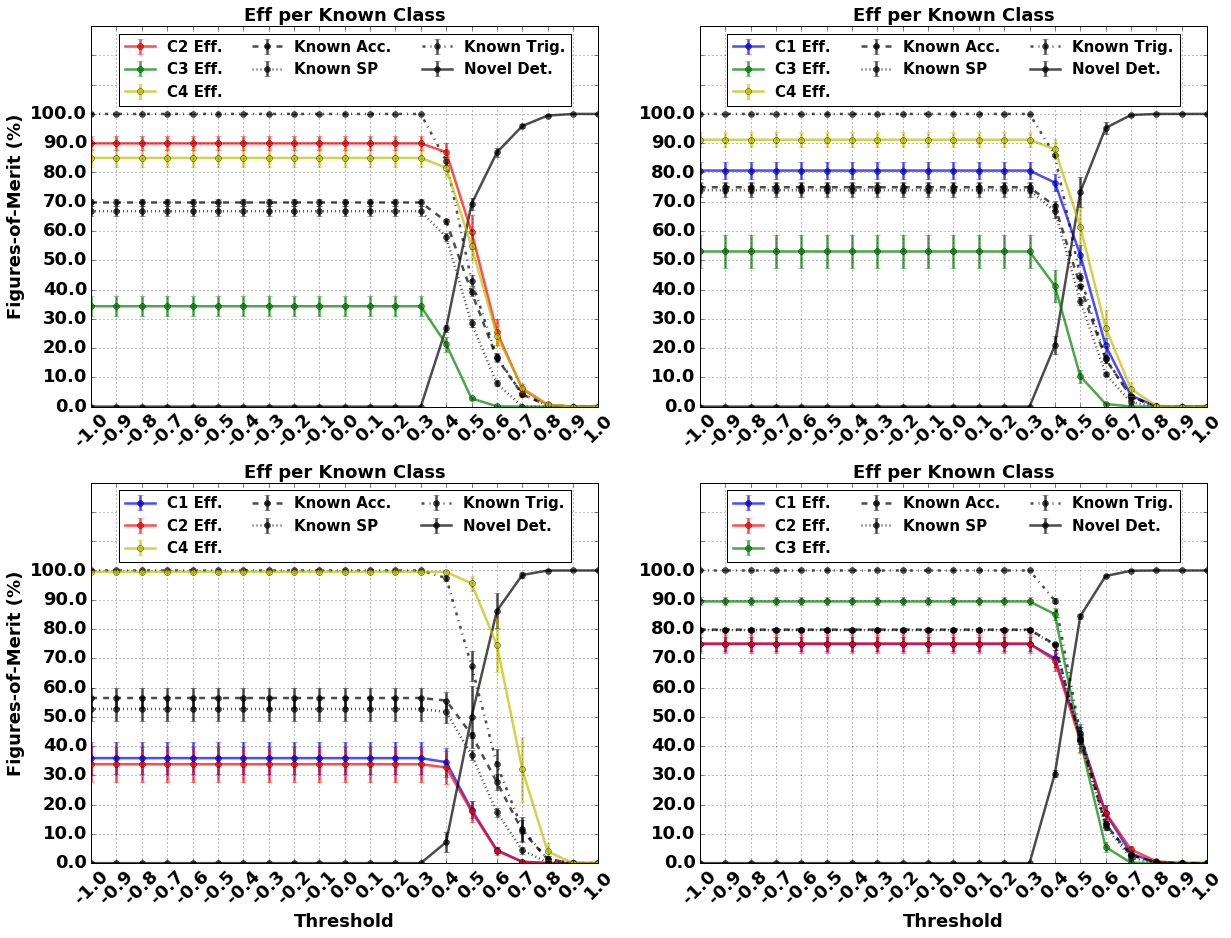

In [34]:
# novelty detection for SAE
# thr. sweep

hidden_neurons = [400, 350, 300]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
    
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_third_layer_thr_sweep.jbl'%(results_path,analysis_str,analysis_name)

# if os.path.exists(analysis_file_name):
#         os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):

    params_str = trn_params.get_params_str()
    
    thr_mat = np.round(np.arange(-1.0,1.1,0.1),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
        trn_data = all_data[all_trgt!=novelty_class]
        trn_trgt = all_trgt[all_trgt!=novelty_class]
        # trgt max = 2
        trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
        
        n_folds = len(CVO[inovelty])
        
        for ifold in range(n_folds):
            print 'Novelty class: %01.0f - topology: %s - fold %i'%(novelty_class, neurons_str, ifold)
            [classifier,trn_desc] = TrainFunctions.SAEClassifierNoveltyTrainFunction(data=trn_data,
                                                   trgt=trn_trgt,
                                                   inovelty=inovelty,
                                                   ifold=ifold,
                                                   n_folds=n_folds,
                                                   hidden_neurons=hidden_neurons,
                                                   trn_params=trn_params,
                                                   save_path=results_path,
                                                   verbose=verbose,
                                                   dev=development_flag)
 
            output = classifier.predict(trn_data)
            novelty_output = classifier.predict(all_data[all_trgt==novelty_class])
            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[trn_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novel Det.')
            ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
            ax.errorbar(thr_mat,np.mean(known_trig_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_trig_mat[:,int(novelty_class),:],axis=0),fmt='o-.',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Trig.')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='C%i Eff.'%(int(m_class)+1))
    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title('Eff per Known Class',fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    ax.set_ylim([0.0, 1.3])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(100*y_ticks[y_ticks<=1.0],fontsize=18)
    
    ax.grid()
    
    if inovelty > 1:
        ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Figures-of-Merit (%)',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
    
    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%s_neurons_%i_fold_'%(neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print trn_params.get_params_str()

# Treinamento da 4ª camada - Número de neurônios definido

In [ ]:
# Choose neurons topology

# hidden_neurons = [first_layer_dim, second_layer_dim, third_layer_dim]
hidden_neurons = [400, 300, 200, 100]

layer = 4
verbose = False

print trn_params.get_params_str()

start_time = time.time()
for inovelty, novelty_class in enumerate(np.unique(trgt)):
    trn_data = all_data[all_trgt!=novelty_class]
    trn_trgt = all_trgt[all_trgt!=novelty_class]

    trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
    
    if inovelty != 0:
        print ''
    print 'Novelty class: %i'%inovelty
    
    # Array with folds to be trained in parallel
    folds = range(len(CVO[inovelty]))
    
    def trainFold(ifold):
        n_folds = len(CVO[inovelty])
        #print 'Neuron value: %i - fold %i'%(ineuron, ifold)
        TrainFunctions.SAENoveltyTrainFunction(data=trn_data,
                                                   trgt=trn_data,
                                                   inovelty=inovelty,
                                                   ifold=ifold,
                                                   n_folds=n_folds,
                                                   n_neurons=hidden_neurons[-1],
                                                   trn_params=trn_params,
                                                   save_path=results_path,
                                                   layer = layer, # Choose the layer to be trained
                                                   hidden_neurons = hidden_neurons[:layer-1],
                                                   verbose=verbose,
                                                   dev=development_flag)
    
    
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)
    
    # To train on multiple cores sweeping the number of neurons
    results = p.map(trainFold, folds)
            
    p.close()
    p.join()        

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

# Autocorrelação da Entrada e Saída - 4ª Camada

In [ ]:
# Reconstruction of Known Classes vs Reconstruction of Novelty - novelty detection for SAE
%matplotlib inline 

# Choose neurons topology
hidden_neurons = [400, 350, 300, 250]
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
    
# Choose model
inovelty = 1

# generate analysis data
save_path=results_path

current_analysis = 'reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData_%i_novelty'%(inovelty)
verbose = False

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

# Check if the analysis has already been performed
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NNNoveltyDetectionTrnParams(n_inits=1,
                                                       hidden_activation='tanh',
                                                       output_activation='linear',
                                                       n_epochs=500,
                                                       patience=30,
                                                       batch_size=256,
                                                       verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NNNoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

novelty_class = float(inovelty)

models = {}
known_outputs = {}
novelty_outputs = {}
mean = {}
indexes = {}

n_folds = len(CVO[inovelty])

for ifold in range(n_folds):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(known_data[test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    if ifold == 0:
        diffSquared = np.zeros([len(CVO[inovelty]), all_data.shape[0], all_data.shape[1]])
    
    print '[*] Loading topology %s for fold %i'%(neurons_str, ifold)
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    
    # Fourth Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2],
                                                            hidden_neurons[3])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the fourth layer projection of data
    fourth_layer_model = load_model(file_name)
    encoder_fourth_layer = fourth_layer_model.layers[0].get_weights()
    decoder_fourth_layer = fourth_layer_model.layers[2].get_weights()
    #third_layer_model.summary()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[3], weights=encoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    
    # Decoder
    model.add(Dense(hidden_neurons[2], weights=decoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    
    outputs = model.predict(norm_data)
    known_outputs[ifold] = model.predict(known_data)
    novelty_outputs[ifold] = model.predict(novelty_data)
    
    diffSquared[ifold] = np.power((norm_data - outputs), 2)

mean = np.mean(np.mean(diffSquared[:,test_id,:], axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    known_data = scaler.transform(known_data[test_id,:])
    
    # normalize novelty classes based on known classes
    novelty_data = all_data[all_trgt==inovelty]
    novelty_data = scaler.transform(novelty_data)
    
    known_points = known_data.shape[0]
    novelty_points = novelty_data.shape[0]
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):  
        ax = plt.subplot(2,2,choose_index+1)
        
        # Plot novelty 
        ax.plot(novelty_data[:,indexes[choose_index]][0], 
                novelty_outputs[ifold][:,indexes[choose_index]][0],
                "r.", label='Novelty Class', markersize=15)
        ax.plot(novelty_data[:,indexes[choose_index]][:novelty_points], 
                novelty_outputs[ifold][:,indexes[choose_index]][:novelty_points],
                "r.", alpha=0.3)
        
        # Plot known classes
        ax.plot(known_data[:,indexes[choose_index]][0],
                known_outputs[ifold][:,indexes[choose_index]][0],
                "b.", label='Known Class', markersize=15)
        ax.plot(known_data[:,indexes[choose_index]][:known_points],
                known_outputs[ifold][:,indexes[choose_index]][:known_points],
                "b.")
        
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.grid() 
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_known_reconstruction = np.power((known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]]), 2)
        eq_novelty_reconstruction = np.power((novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]]), 2)
        
        mq_bins_known = np.linspace(np.min(eq_known_reconstruction), np.max(eq_known_reconstruction), 50)
        mq_bins_novelty = np.linspace(np.min(eq_novelty_reconstruction), np.max(eq_novelty_reconstruction), 50)
             
        n, bins, patches = ax1.hist(eq_novelty_reconstruction,bins=mq_bins_novelty,
                                    fc="r",
                                    alpha=0.5, normed=0)
        
        n, bins, patches = ax1.hist(eq_known_reconstruction,bins=mq_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax1.set_xlim(0, 0.8)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_known_reconstruction = (known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]])
        e_novelty_reconstruction = (novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]])
        
        m_bins_known = np.linspace(np.min(e_known_reconstruction), np.max(e_known_reconstruction), 50)
        m_bins_novelty = np.linspace(np.min(e_novelty_reconstruction), np.max(e_novelty_reconstruction), 50)
        
        n, bins, patches = ax2.hist(e_novelty_reconstruction,bins=m_bins_novelty,
                                    fc="r",
                                    alpha=0.6, normed=0)
        
        n, bins, patches = ax2.hist(e_known_reconstruction,bins=m_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-1.4,1.4) 
        
        ax.legend(handles, labels, ncol=1, loc='upper right')
        plt.legend()
        
        mse = metrics.mean_squared_error(known_data[:,indexes[choose_index]], known_outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 3, 'MSE: %f'%mse, style='normal',fontsize=20, color='blue',
        bbox={'alpha':0.0, 'pad':10})
        
        mse = metrics.mean_squared_error(novelty_data[:,indexes[choose_index]], novelty_outputs[ifold][:,indexes[choose_index]])
        ax.text(4, 2.5, 'MSE: %f'%mse, style='normal',fontsize=20, color='red',
        bbox={'alpha':0.0, 'pad':10})
        
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_fourth_layer_%s_neurons_%i_fold_'%(neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

[*] Loading topology 400x400x350x300x250 for fold 0
[*] Loading topology 400x400x350x300x250 for fold 1
[*] Loading topology 400x400x350x300x250 for fold 2
[*] Loading topology 400x400x350x300x250 for fold 3
[*] Loading topology 400x400x350x300x250 for fold 4
[*] Loading topology 400x400x350x300x250 for fold 5


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

# Choose neurons topology
hidden_neurons = [400, 350, 300, 250]
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
    
# Choose model
inovelty = 1

# generate analysis data
save_path=results_path

current_analysis = 'LOFARGram_reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData_%i_novelty'%(inovelty)

# Create a string like InputDimension x FirstLayerDimension x ... x OutputDimension
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
print 'Topology for %i class as novelty'%inovelty

for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)

    known_data = norm_data[all_trgt!=inovelty][test_id,:]
    novelty_data = norm_data[all_trgt==inovelty]
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    #first_layer_model.summary()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    #second_layer_model.summary()
    
    # Third Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    third_layer_model = load_model(file_name)
    encoder_third_layer = third_layer_model.layers[0].get_weights()
    decoder_third_layer = third_layer_model.layers[2].get_weights()
    
    # Fourth Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_400x%ix%ix%ix%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0],
                                                            hidden_neurons[1],
                                                            hidden_neurons[2],
                                                            hidden_neurons[3])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the third layer projection of data
    fourth_layer_model = load_model(file_name)
    encoder_fourth_layer = fourth_layer_model.layers[0].get_weights()
    decoder_fourth_layer = fourth_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[2], weights=encoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[3], weights=encoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    # Decoder
    model.add(Dense(hidden_neurons[2], weights=decoder_fourth_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(hidden_neurons[1], weights=decoder_third_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)
    print '[*] Loading Fold %i'%ifold
    m_fontsize = 12
    
    fig, subplot_array = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        if i == 0:
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")
            plt.imshow(norm_data[all_trgt==inovelty,:],
               cmap="jet",extent=[1, 400, norm_data[all_trgt==inovelty,:].shape[0],1],
               aspect="auto")
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
            plt.title('Lofar Analysis for Original Data of %s'%(class_labels[inovelty]), fontsize= m_fontsize, fontweight="bold")
        if (i == 1):
            plt.imshow(all_output[all_trgt==inovelty,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==inovelty,:].shape[0],1],
               aspect="auto")
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
            plt.title('Lofar Analysis for Reconstructed Data of %s'%(class_labels[inovelty]), fontsize= m_fontsize, fontweight="bold")
       
        plt.xticks(np.linspace(0,400,9),rotation=45)
        if i == 1:
            cbar = plt.colorbar()
            cbar.ax.set_ylabel('dB',fontweight='bold') 
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_fourth_layer_%s_neurons_%i_fold_'%(inovelty, neurons_str,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()
    

# Análise da Variação de Thresholds - 4ª camada

Novelty class: 0 - topology: 400x400x350x300x250 - fold 0
Novelty class: 0 - topology: 400x400x350x300x250 - fold 1
Novelty class: 0 - topology: 400x400x350x300x250 - fold 2
Novelty class: 0 - topology: 400x400x350x300x250 - fold 3
Novelty class: 0 - topology: 400x400x350x300x250 - fold 4
Novelty class: 0 - topology: 400x400x350x300x250 - fold 5
Novelty class: 0 - topology: 400x400x350x300x250 - fold 6
Novelty class: 0 - topology: 400x400x350x300x250 - fold 7
Novelty class: 0 - topology: 400x400x350x300x250 - fold 8
Novelty class: 0 - topology: 400x400x350x300x250 - fold 9
Novelty class: 1 - topology: 400x400x350x300x250 - fold 0
Novelty class: 1 - topology: 400x400x350x300x250 - fold 1
Novelty class: 1 - topology: 400x400x350x300x250 - fold 2
Novelty class: 1 - topology: 400x400x350x300x250 - fold 3
Novelty class: 1 - topology: 400x400x350x300x250 - fold 4
Novelty class: 1 - topology: 400x400x350x300x250 - fold 5
Novelty class: 1 - topology: 400x400x350x300x250 - fold 6
Novelty class:

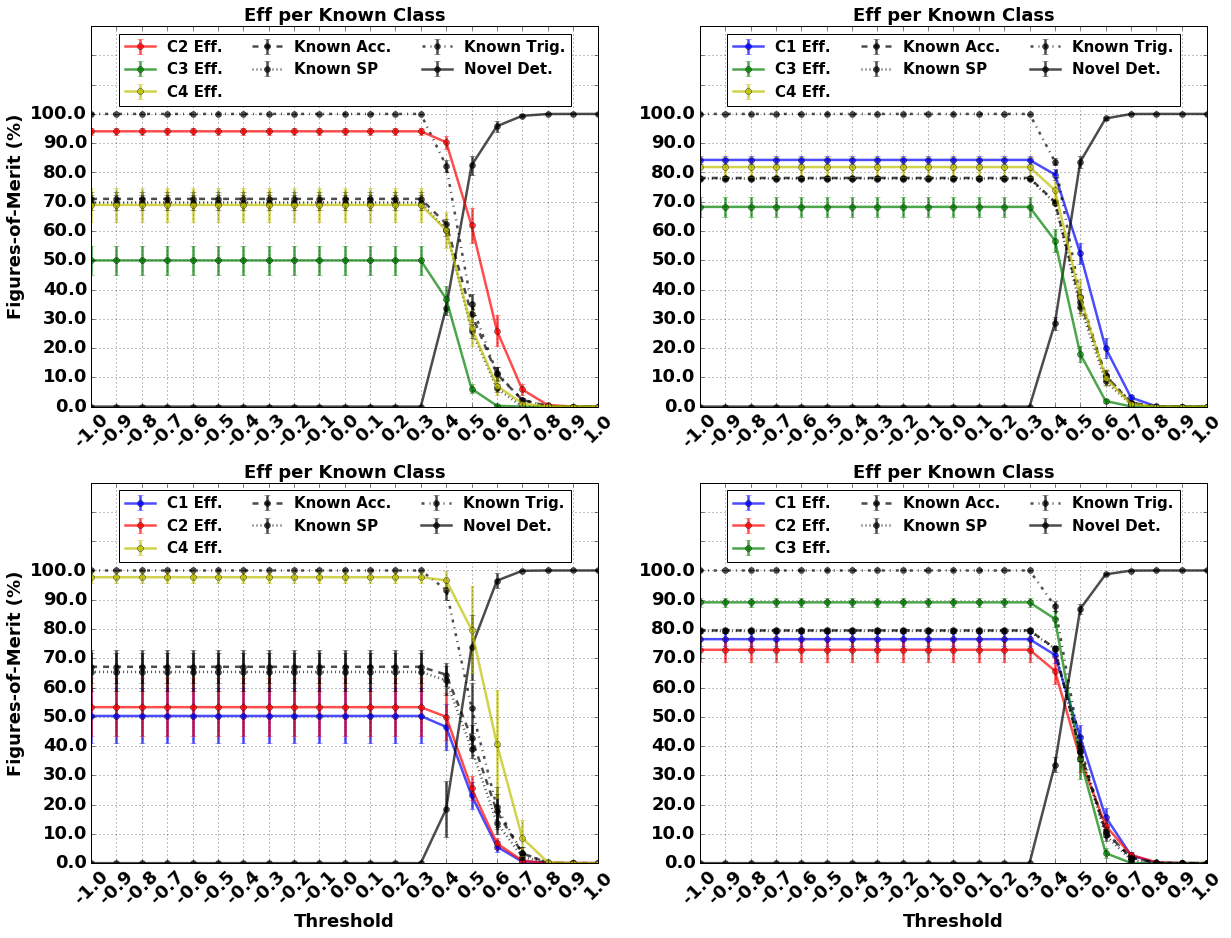

In [35]:
# novelty detection for SAE
# thr. sweep

hidden_neurons = [400, 350, 300, 250]

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
    
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_fourth_layer_thr_sweep.jbl'%(results_path,analysis_str,analysis_name)

# if os.path.exists(analysis_file_name):
#         os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):

    params_str = trn_params.get_params_str()
    
    thr_mat = np.round(np.arange(-1.0,1.1,0.1),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
        trn_data = all_data[all_trgt!=novelty_class]
        trn_trgt = all_trgt[all_trgt!=novelty_class]
        # trgt max = 2
        trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
        
        n_folds = len(CVO[inovelty])
        
        for ifold in range(n_folds):
            print 'Novelty class: %01.0f - topology: %s - fold %i'%(novelty_class, neurons_str, ifold)
            [classifier,trn_desc] = TrainFunctions.SAEClassifierNoveltyTrainFunction(data=trn_data,
                                                   trgt=trn_trgt,
                                                   inovelty=inovelty,
                                                   ifold=ifold,
                                                   n_folds=n_folds,
                                                   hidden_neurons=hidden_neurons,
                                                   trn_params=trn_params,
                                                   save_path=results_path,
                                                   verbose=verbose,
                                                   dev=development_flag)
 
            output = classifier.predict(trn_data)
            novelty_output = classifier.predict(all_data[all_trgt==novelty_class])
            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[trn_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novel Det.')
            ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
            ax.errorbar(thr_mat,np.mean(known_trig_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_trig_mat[:,int(novelty_class),:],axis=0),fmt='o-.',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Trig.')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='C%i Eff.'%(int(m_class)+1))
    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title('Eff per Known Class',fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    ax.set_ylim([0.0, 1.3])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(100*y_ticks[y_ticks<=1.0],fontsize=18)
    
    ax.grid()
    
    if inovelty > 1:
        ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Figures-of-Merit (%)',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
    
    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%s_neurons_'%(neurons_str)+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print trn_params.get_params_str()